# Model Hamiltonians in Libra

## Table of Content: <a name="TOC"></a>

1. [Define the model Hamiltonians](#define_models)

  1.1. [Hamiltonian in diabatic basis](#ham_dia)
  
  1.2. [Hamiltonian in adiabatic basis](#ham_adi)
 
  1.3. [Hamiltonian in adiabatic basis, via files](#ham_adi_files)
  

2. [PES scan & plotting](#pes_scan)

 2.1. [Option 1: Diabatic properties](#pes_scan-1)
 
 2.2. [Option 2: Adiabatic properties via numeric adiabatization](#pes_scan-2)

 2.3. [Option 3: Adiabatic properties via analytic form of Hamiltonian in adiabatic representation](#pes_scan-3)
 
 2.4. [Option 4: Adiabatic properties via file-based Hamiltonian](#pes_scan-4)


## A. Learning objectives

- to be able to define your model Hamiltonian that returns diabatic or adiabatic properties
- to be able to define a model Hamiltonian that "computes" via reading files
- to be able to use the defined Hamiltonian calculation function in plotting of PES and other properties
- to be able to use plot Hamiltonian matrix elements vs. time-coordinate
- to be able to setup an HDF5 saver and use it to store various types of data 
- to be able to explore the content of HDF5 files and read their content


## B. Use cases

- [Define diabatic abstract model Hamiltonian](#ham_abs_dia)
- [Define adiabatic abstract model Hamiltonian](#ham_abs_adi)
- [Define adiabatic file-based model Hamiltonian](#ham_fil_adi)
- Plotting 1D PES [Ex1](#1d_pes_plotting1-ex1) | [Ex2](#1d_pes_plotting1-ex2) | [Ex3](#1d_pes_plotting1-ex3)
- Plotting diabatic-to-adiabatic transformaitons vs. coordinate in 1D [Ex1](#1d_pes_plotting2-ex1) | [Ex2](#1d_pes_plotting2-ex2)
- [Plotting 1D PES vs. time](#1d_pes_plotting3)


## C. Functions

- `libra_py`
  - `dynamics_plotting`
   - `plot_pes_properties` [Ex1](#plot_pes_properties-ex1) | [Ex2](#plot_pes_properties-ex2) | [Ex3](#plot_pes_properties-ex3)
   - `plot_surfaces` [Ex1](#plot_surfaces-ex1) | [Ex2](#plot_surfaces-ex2)

## D. Classes and class members
    
- `libra_py`
  - `data_savers`
   - `hdf5_saver`
     - [`set_compression_level`](#set_compression_level)      
     - [`add_dataset`](#add_dataset)      
     - [`save_matrix`](#save_matrix)      
     - [`hdf5_saver`](#hdf5_saver)           



In [1]:
import sys
import cmath
import math
import os
import h5py

import matplotlib.pyplot as plt   # plots
import numpy as np
%matplotlib inline 


if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
from libra_py import data_conv
from libra_py.data_visualize import colors, clrs_index
import libra_py.dynamics_plotting as dynamics_plotting
import libra_py.data_savers as data_savers


/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::all

<a name="define_models"></a></a>[Back to TOC](#TOC)
## 1. Define the models

To run any types of calculations, we need to define how energies, forces, derivative couplings, etc. are computed.
This is done in a Python function, which is expected to follow to rules:

1. the input parameters of the function are always: 

   * `q` ( MATRIX(ndof, 1) ) - coordinates of the system
   
   * `params` (Python dictionary) - model parameters
   
   * `full_id` (intList) - the identifier of the child - for the (parent) Hamiltonian object to know which of its 
     children to refer to for this particular calculation. This is needed for instance to enable multiple-trajectories 
     simulations at once.
      
      
2. the output object **has to have special names** of the returned instance of a class

   * `ham_dia` ( CMATRIX(ndia, ndia) ) - Hamiltonian in the diabatic representation 
   * `ham_adi` ( CMATRIX(nadi, nadi) ) - Hamiltonian in the adiabatic representation 
   * `ovlp_dia` ( CMATRIX(ndia, ndia) ) - the overlap of the diabatic states
   * `d1ham_dia` ( vector of CMATRIX(ndia, ndia) ) - the derivatives of the H_dia w.r.t. all nuclear coordinates
   * `d1ham_adi` ( vector of CMATRIX(nadi, nadi) ) - the derivatives of the H_adi w.r.t. all nuclear coordinates
   * `dc1_dia` ( vector of CMATRIX(ndia, ndia) ) - the derivatives couplings in the diabatic representation, w.r.t. all the nuclear coordinates   
   * `dc1_adi` ( vector of CMATRIX(ndia, ndia) ) - the derivatives couplings in the adiabatic representation, w.r.t. all the nuclear coordinates   

   The object returned by the function can define any of these variables. Depending on the type of calculations (dynamical workflow) the model Hamiltonian (Python) function will be called, some of these variables will be expected to be present, others - not. 
   

<a name="ham_dia"></a><a name="ham_abs_dia"></a>[Back to TOC](#TOC)

### 1.1. Hamiltonian is defined in diabatic basis

First, we define a function to compute only the diabatic properties:

In [2]:
class tmp:
    pass

def my_test_dia_abstract(q, params, full_id):
    """
   
    2-state spin-boson model [Ref: Subotnik, JCP 135, 191101, 2011]

         | 0.5*m*w^2*x^2 + M*x          V                    |
    H =  |                                                   |
         |       V               0.5*m*w^2*x^2 - M*x - eps   |
         

    M = sqrt(E_r * m * w^2 / 2)
    

    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof = 1
        params ( dictionary ): model parameters

            * **params["omega"]** ( double ):  [ units: a.u. ]
            * **params["E_r"]**   ( double ):  [ units: Ha ]
            * **params["mass"]** ( double ):  [ units: a.u. ]
            * **params["V"]**   ( double ):  [ units: Ha ]
            * **params["epsilon"]**   ( double ):  [ units: Ha ]

    Returns:       
        PyObject: obj, with the members:

            * obj.ham_dia ( CMATRIX(n,n) ): diabatic Hamiltonian 
            * obj.ovlp_dia ( CMATRIX(n,n) ): overlap of the basis (diabatic) states [ identity ]
            * obj.d1ham_dia ( list of 1 CMATRIX(n, n) objects ): 
                derivatives of the diabatic Hamiltonian w.r.t. the nuclear coordinate
            * obj.dc1_dia ( list of 1 CMATRIX(n, n) objects ): derivative coupling in the diabatic basis [ zero ]
 
    """


    critical_params = [] 
    default_params = { "omega":3.5e-4, "E_r":2.39e-2, "mass":1.0, "V":1.49e-5, "epsilon":1.5e-2  }
    comn.check_input(params, default_params, critical_params)

    omega = params["omega"]
    E_r = params["E_r"]
    mass = params["mass"]
    V = params["V"]
    epsilon = params["epsilon"]
    
    n = 2

    Hdia = CMATRIX(n,n)
    Sdia = CMATRIX(n,n)
    d1ham_dia = CMATRIXList();  d1ham_dia.append( CMATRIX(n,n) )
    dc1_dia = CMATRIXList();  dc1_dia.append( CMATRIX(n,n) )
  
    Id = Cpp2Py(full_id)
    indx = Id[-1]

    x = q.col(indx).get(0)
    
    Sdia.identity()    
    
    M = omega * math.sqrt(0.5*E_r * mass)
    
    Hdia.set(0,0,  (0.5*mass*omega*omega*x*x + M *x )  * (1.0+0.0j) )
    Hdia.set(1,1,  (0.5*mass*omega*omega*x*x - M *x - epsilon )  * (1.0+0.0j) )
    Hdia.set(0,1,  V  * (1.0+0.0j) )
    Hdia.set(1,0,  V  * (1.0+0.0j) )
            
    d1ham_dia[0].set(0, 0, (omega*omega*x + M)*(1.0+0.0j) )    
    d1ham_dia[0].set(1, 1, (omega*omega*x - M)*(1.0+0.0j) )    
    d1ham_dia[0].set(0, 1, (0.0+0.0j) )    
    d1ham_dia[0].set(1, 0, (0.0+0.0j) )    
            
                    
    obj = tmp()
    obj.ham_dia = Hdia
    obj.ovlp_dia = Sdia
    obj.d1ham_dia = d1ham_dia
    obj.dc1_dia = dc1_dia

    return obj


### Exercise 1

Define a 3-state Hamiltonian with 1 nuclear DOF - a "superexchange" model

### Exercise 2

Define a 2-level Hamiltonian with 2 nuclear DOFs - the "Mexican hat" potential

<a name="ham_adi"></a><a name="ham_abs_adi"></a>[Back to TOC](#TOC)
### 1.2. Hamiltonian is defined in adiabatic basis

Second, we a function to compute only the adiabatic properties. This is done analytically in a closed form, which means we don't need to rely on a diabatic-to-adiabatic transformation (eigenvalue problem soluton), which may be affected by the phase insconsistencies and state reordering. In general, though, such analytic formulation is not possible, but this type of function is meant to mimic a situation where you only get the adiabatic properties - e.g. from some *ab initio* calculations, which usually give the adiabatic properties as the main result.

Note how the object returned by this function has different members, in particular, the `basis_transform` - something that is usually obtained by the diagonalization of the diabatic Hamiltonian.

In [3]:
def my_test_adi_abstract(q, params, full_id):
    """
   
    2-state spin-boson model [Ref: Subotnik, JCP 135, 191101, 2011]

         | 0.5*m*w^2*x^2 - eps/2 - sqrt( (eps/2 + M*x)^2 + V^2 )          d12 * i          |
    H =  |                                                                                 | 
         |       -d12 * i      0.5*m*w^2*x^2 - eps/2 - sqrt( (eps/2 + M*x)^2 + V^2 )       |
         

    M = sqrt(E_r * m * w^2 / 2)
    
    d12 = 0.5 * M * V / [ (eps/2 +  M*x)^2 + V^2 ]
    

    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof = 1
        params ( dictionary ): model parameters

            * **params["omega"]** ( double ):  [ units: a.u. ]
            * **params["E_r"]**   ( double ):  [ units: Ha ]
            * **params["mass"]** ( double ):  [ units: a.u. ]
            * **params["V"]**   ( double ):  [ units: Ha ]
            * **params["epsilon"]**   ( double ):  [ units: Ha ]

    Returns:       
        PyObject: obj, with the members:

            * obj.ham_dia ( CMATRIX(n,n) ): diabatic Hamiltonian 
            * obj.ovlp_dia ( CMATRIX(n,n) ): overlap of the basis (diabatic) states [ identity ]
            * obj.d1ham_dia ( list of 1 CMATRIX(n, n) objects ): 
                derivatives of the diabatic Hamiltonian w.r.t. the nuclear coordinate
            * obj.dc1_dia ( list of 1 CMATRIX(n, n) objects ): derivative coupling in the diabatic basis [ zero ]
    """


    critical_params = [] 
    default_params = { "omega":3.5e-4, "E_r":2.39e-2, "mass":1.0, "V":1.49e-5, "epsilon":1.5e-2  }
    comn.check_input(params, default_params, critical_params)

    omega = params["omega"]
    E_r = params["E_r"]
    mass = params["mass"]
    V = params["V"]
    epsilon = params["epsilon"]
    
    n = 2

    Hadi = CMATRIX(n,n)
    u = CMATRIX(n,n)
    d1ham_adi = CMATRIXList();  d1ham_adi.append( CMATRIX(n,n) )
    dc1_adi = CMATRIXList();  dc1_adi.append( CMATRIX(n,n) )
  
    Id = Cpp2Py(full_id)
    indx = Id[-1]

    x = q.col(indx).get(0)

    
    M = omega * math.sqrt(0.5*E_r * mass)
    
    t = (epsilon/2.0 +  M*x)**2 + V * V 
    tsq = math.sqrt(t)
    dtsq = M * (epsilon/2.0 + M*x)/tsq   # d [tsq]/dx
    d = 0.5*M*V/t
        
    
    Hadi.set(0,0,  (0.5*mass*omega*omega*x*x - 0.5*epsilon - tsq) * (1.0+0.0j) )
    Hadi.set(1,1,  (0.5*mass*omega*omega*x*x - 0.5*epsilon + tsq) * (1.0+0.0j) )
    Hadi.set(0,1,  (0.0+0.0j) )
    Hadi.set(1,0,  (0.0+0.0j) )
            
    d1ham_adi[0].set(0, 0, (omega*omega*x - dtsq )*(1.0+0.0j) )    
    d1ham_adi[0].set(1, 1, (omega*omega*x + dtsq )*(1.0+0.0j) )    
    d1ham_adi[0].set(0, 1, (0.0+0.0j) )    
    d1ham_adi[0].set(1, 0, (0.0+0.0j) )    
    
    dc1_adi[0].set(0, 1, d*(1.0+0.0j) )    
    dc1_adi[0].set(1, 0, d*(-1.0+0.0j) )    
    dc1_adi[0].set(0, 0, (0.0+0.0j) )    
    dc1_adi[0].set(1, 1, (0.0+0.0j) )   
    
    u.set(0, 0, math.sqrt(0.5 - 0.5 * dtsq) * (1.0 + 0.0j))
    u.set(1, 0, math.sqrt(0.5 + 0.5 * dtsq) * (-1.0 + 0.0j))    
    u.set(0, 1, math.sqrt(0.5 + 0.5 * dtsq) * (1.0 + 0.0j))
    u.set(1, 1, math.sqrt(0.5 - 0.5 * dtsq) * (1.0 + 0.0j))
            
                    
    obj = tmp()
    obj.ham_adi = Hadi    
    obj.d1ham_adi = d1ham_adi
    obj.dc1_adi = dc1_adi
    obj.basis_transform = u

    return obj


### Exercise 3

Define a 2-level Hamiltonian (adiabatic), in which only 1 nuclear DOF is directly coupled to electronic variables, whereas all other N-1 ( for general N ) nuclear DOFs are coupled to their neighbors only via Harmonic potential - the Parandekar-Tully linear chain model. 

<a name="ham_adi_files"></a><a name="ham_fil_adi"></a>[Back to TOC](#TOC)
### 1.3. Hamiltonian is defined in adiabatic basis, but via reading files

In addition, lets define yet another version of the Hamiltonian setup function, `my_test_adi_files`, which really just reads the existing files (with vibronic Hamiltonians) and returns the object that contains the `hvib_adi` member with such matrices. 

This function is meant to be used with the neglect of back-reaction (NBRA)-type calculations, when the (vibronic) Hamiltonians or any other matrices, pre-computed for each geometry. 


Unlike in the previous setups, the `params` variable is now expected to contain two keys:

* `filename` - indicates the name of the file to read. In this example, we assume the file is in a HDF5 format and contains the needed variables. 

* `timestep` - the index of the matrices to read. If this function is used in the dynamics, this index should correspond to the integration timestep. This parameter is changed in the `dynamics.run_dynamics` function before the call of this Hamiltonian evaluation is made. This way, one can read the files for particular timesteps in the dynamics.


In [11]:
def my_test_adi_files(q, params, full_id):
    """
   
    Read in the vibronic Hamiltonians along the trajectories
    
    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof = 1, but they do not really affect anything
        params ( dictionary ): model parameters

            * **params["timestep"]** ( int ):  [ index of the file to read ]            
            * **params["filename"]** ( string ):  [ the name of the HDF5 file ]
        

    Returns:       
        PyObject: obj, with the members:

            * obj.hvib_adi ( CMATRIX(n,n) ): adiabatic vibronic Hamiltonian 
            
    """
    
                                
    H_vib_adi = None
  
    Id = Cpp2Py(full_id)
    indx = Id[-1]    
    timestep = params["timestep"]    
    filename = params["filename"]
                
    with h5py.File(filename, 'r') as f:
                                
        nadi = int(f["hvib_adi/data"].shape[1] )
                    
        H_vib_adi = CMATRIX(nadi, nadi)                                
        for i in range(nadi):
            for j in range(nadi):
                H_vib_adi.set(i,j, complex( f["hvib_adi/data"][timestep, i, j]) )                
                        
    obj = tmp()
    obj.hvib_adi = H_vib_adi        
    obj.ham_adi = CMATRIX(H_vib_adi.real() )

    return obj

### Exercise 4.

Adapt the function above to read other information from the data files - such as diabatic and adiabatic Hamiltonians, derivative couplings, and diabatic-to-adiabatic transformation matrices.

To unify the interface for all of the three cases, lets define a `compute_model` function, which would call the appropriate specialization, depending on the index of the model type selected:

In [5]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:
        res = my_test_dia_abstract(q, params, full_id)
    elif model==2:
        res = my_test_adi_abstract(q, params, full_id)
    elif model==3: 
        res = my_test_adi_files(q, params, full_id)        

    return res


<a name="pes_scan"></a>
[Back to TOC](#TOC)

## 2. PES scan

Now, we will demonstrate several functions to perform the calculations of the Hamiltonian properties along some search/scan directions.

First, lets consider 3 special situations:

<a name="pes_scan-1"></a>
[Back to TOC](#TOC)

### 2.1. Option 1: Diabatic properties


We want the diabatic properties ( `pes_params["rep_tdse"]=0`) and the model Hamiltonian that we have define (`my_test_dia_abstract` ) does return the diabatic properties (`pes_params["rep_ham"]=1`). 

In this situation, no additional diagonalization of the diabatic Hamiltonian will be requested in the underlying calculations, so the adiabatic properties aren't available - the plotting below is not showing anything in the right column.

The calculations and plotting are done with the function `plot_pes_properties` or the `libra_py.dynamics_plotting` module. 

The function takes 4 key parameters:



In [6]:
help(dynamics_plotting.plot_pes_properties)

Help on function plot_pes_properties in module libra_py.dynamics_plotting:

plot_pes_properties(comp_model, model_params, pes_params_, plot_params_)
    Args:
    
        comp_model ( PyObject ): the function that returns the class with Hamiltonian properties
        
        model_params ( dictionary ): parameters of the model Hamiltonian
        
        pes_params_ ( dictionary ): controls the way the calculations are done
        
            Can contain the following parameters
            
            * **pes_params["ndia"]** ( int ): dinemsionality of the diabatic Hamiltonian [ default: 2 ]
            * **pes_params["nadi"]** ( int ): dinemsionality of the adiabatic Hamiltonian [ default: 2 ]
            * **pes_params["ndof"]** ( int ): the number of nuclear DOF [ default: 1 ]
            * **pes_params["coord_type"]** ( 0 or 1 ): 0 - actual coordinate, 1 - time coordinate [ default: 0 ]
            * **pes_params["xmin"]** ( double ): minimal range of PES scan, matters only 

Lets decipher some more details:

* `pes_params["ndia"] = 2` - our model Hamiltonian is formulated for 2 diabatic electronic states 
* `pes_params["nadi"] = 2` - our model Hamiltonian is formulated for 2 adiabatic electronic states
* `pes_params["ndof"] = 1` - our model Hamiltonian is formulated for 1 nuclear degree of freedom

Parameters `pes_params["xmin"]`, `pes_params["xmax"]`, and `pes_params["dx"]` should be intuitive
Parameters `pes_params["rep_tdse"]` and `pes_params["res_ham"]` are mentioned above

Now, as far as the parameters of the `plot_params` dictionary go:

* `plot_params["which_ham_dia"] = [ [0,0], [1,1], [0,1] ]` - we request to plot the following matrix elements of the diabatic Hamiltonian: $H_{0,0}$, $H_{1,1}$, and $H_{0,1}$

* `plot_params["which_d1ham_dia"] = [ [0, 0,0], [0, 1,1], [0, 0,1] ]` - we request to plot the following matrix elements of the derivative of diabatic Hamiltonian: $dH_{0,0} / dR_{0}$, $dH_{1,1} / dR_{0}$, and $dH_{0,1} / dR_{0}$

* `plot_params["which_dc1_dia"] = [ [0, 0,1] ]` - we request to plot the following matrix elements of the derivative coupling in diabatic basis: $< \psi^{dia}_{0} | \frac{d}{dR_{0}} | \psi^{dia}_{1} >$

* `plot_params["colors"] = colors` and `plot_params["clrs_index"] = clrs_index` - these variables define the colors of the lines and the mapping of the colors to the number of the line. In this particular example, we simply use the predefined sets imported from the `libra_py.data_visualize` module, but you can redefine them on your own. 

The second argument to this function - `{"model":1}` simply selects the `my_test_dia_abstract` function to be used for the calculations. 

You can also specify additional parameters that this function accepts (e.g. `omega`, `E_r`, `mass`, etc.), but if you don't do it - the default parameters will be used, so the input is very minimalistic.

<a name="1d_pes_plotting1-ex1"></a>
<a name="plot_pes_properties-ex1"></a>

No handles with labels found to put in legend.


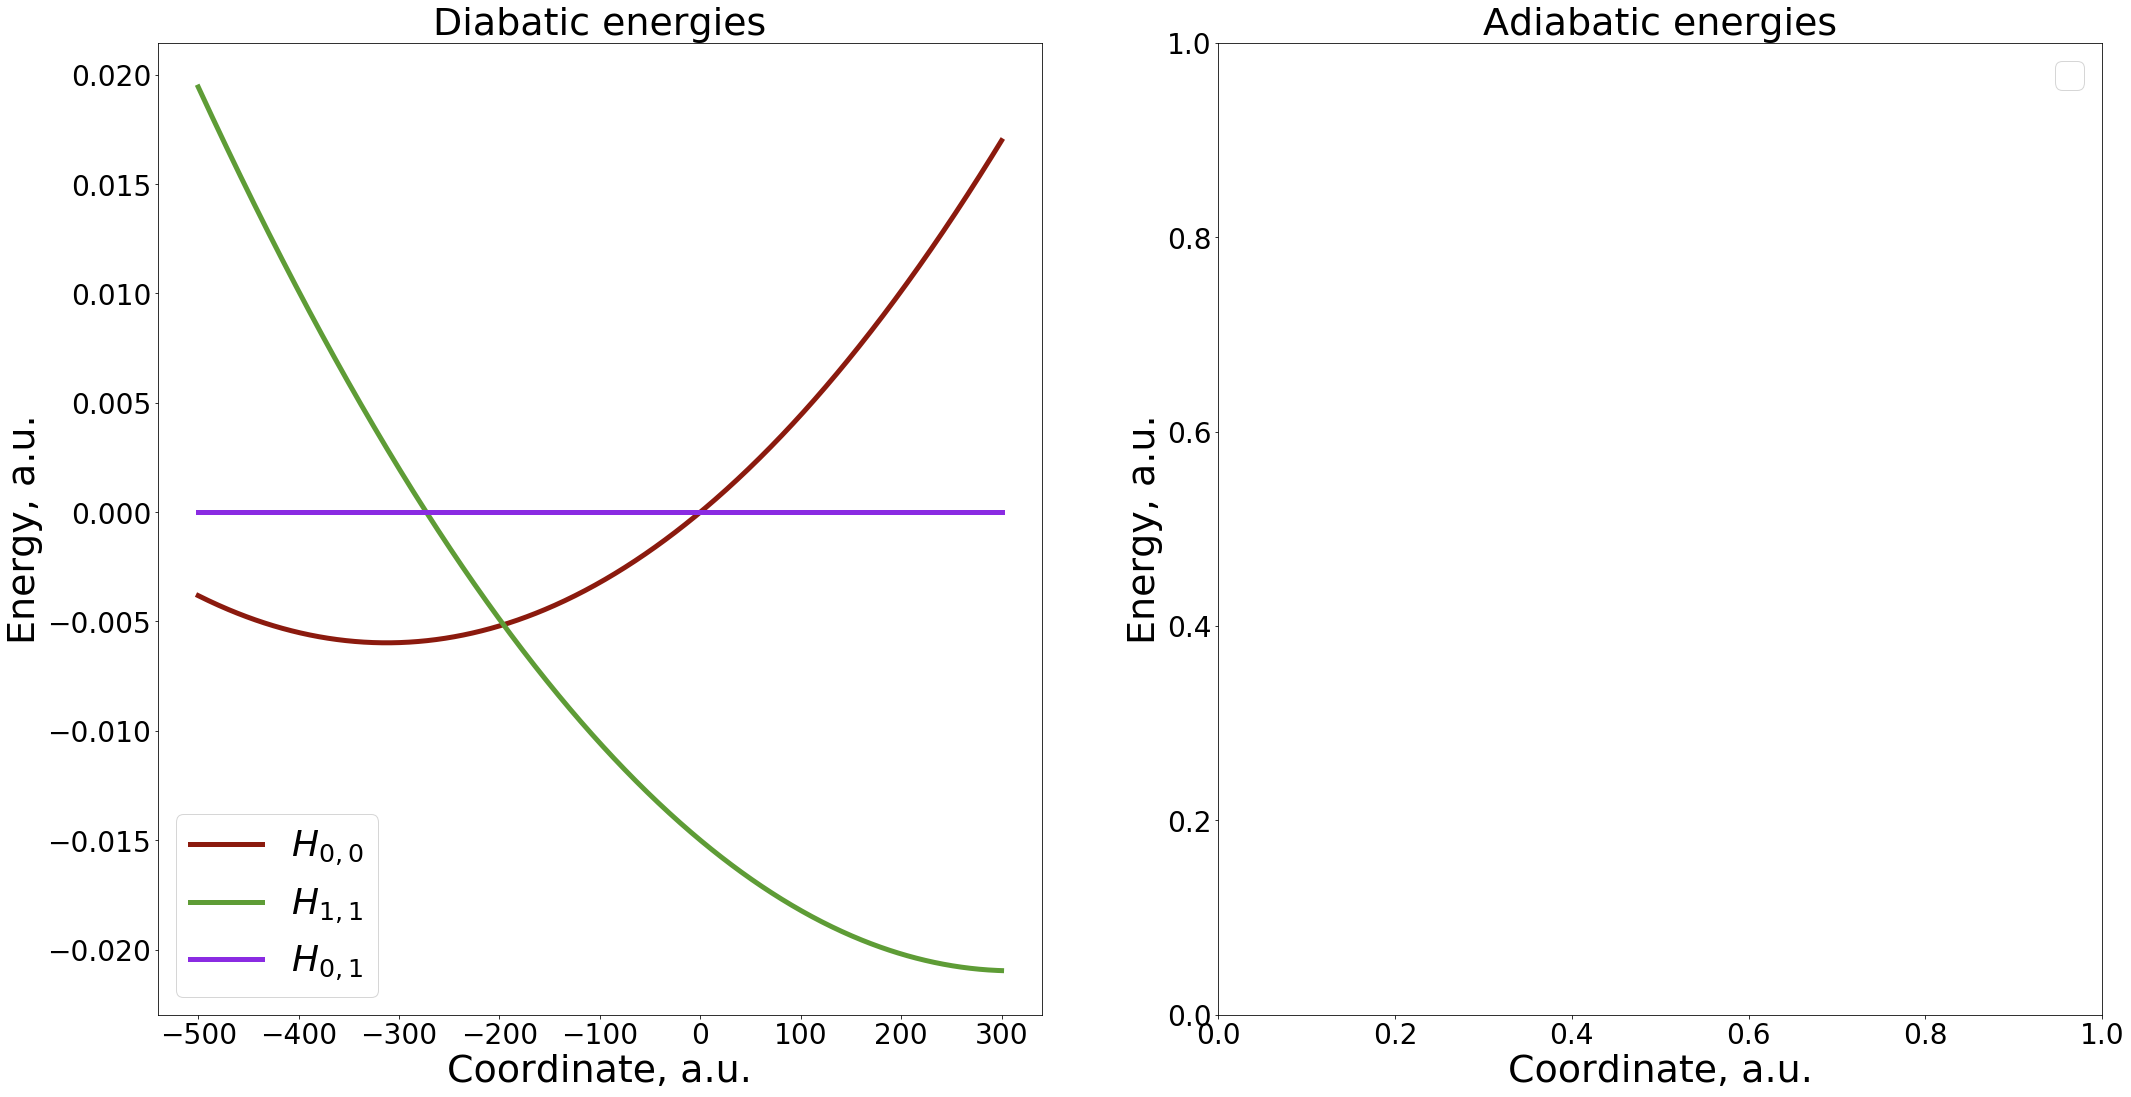

No handles with labels found to put in legend.


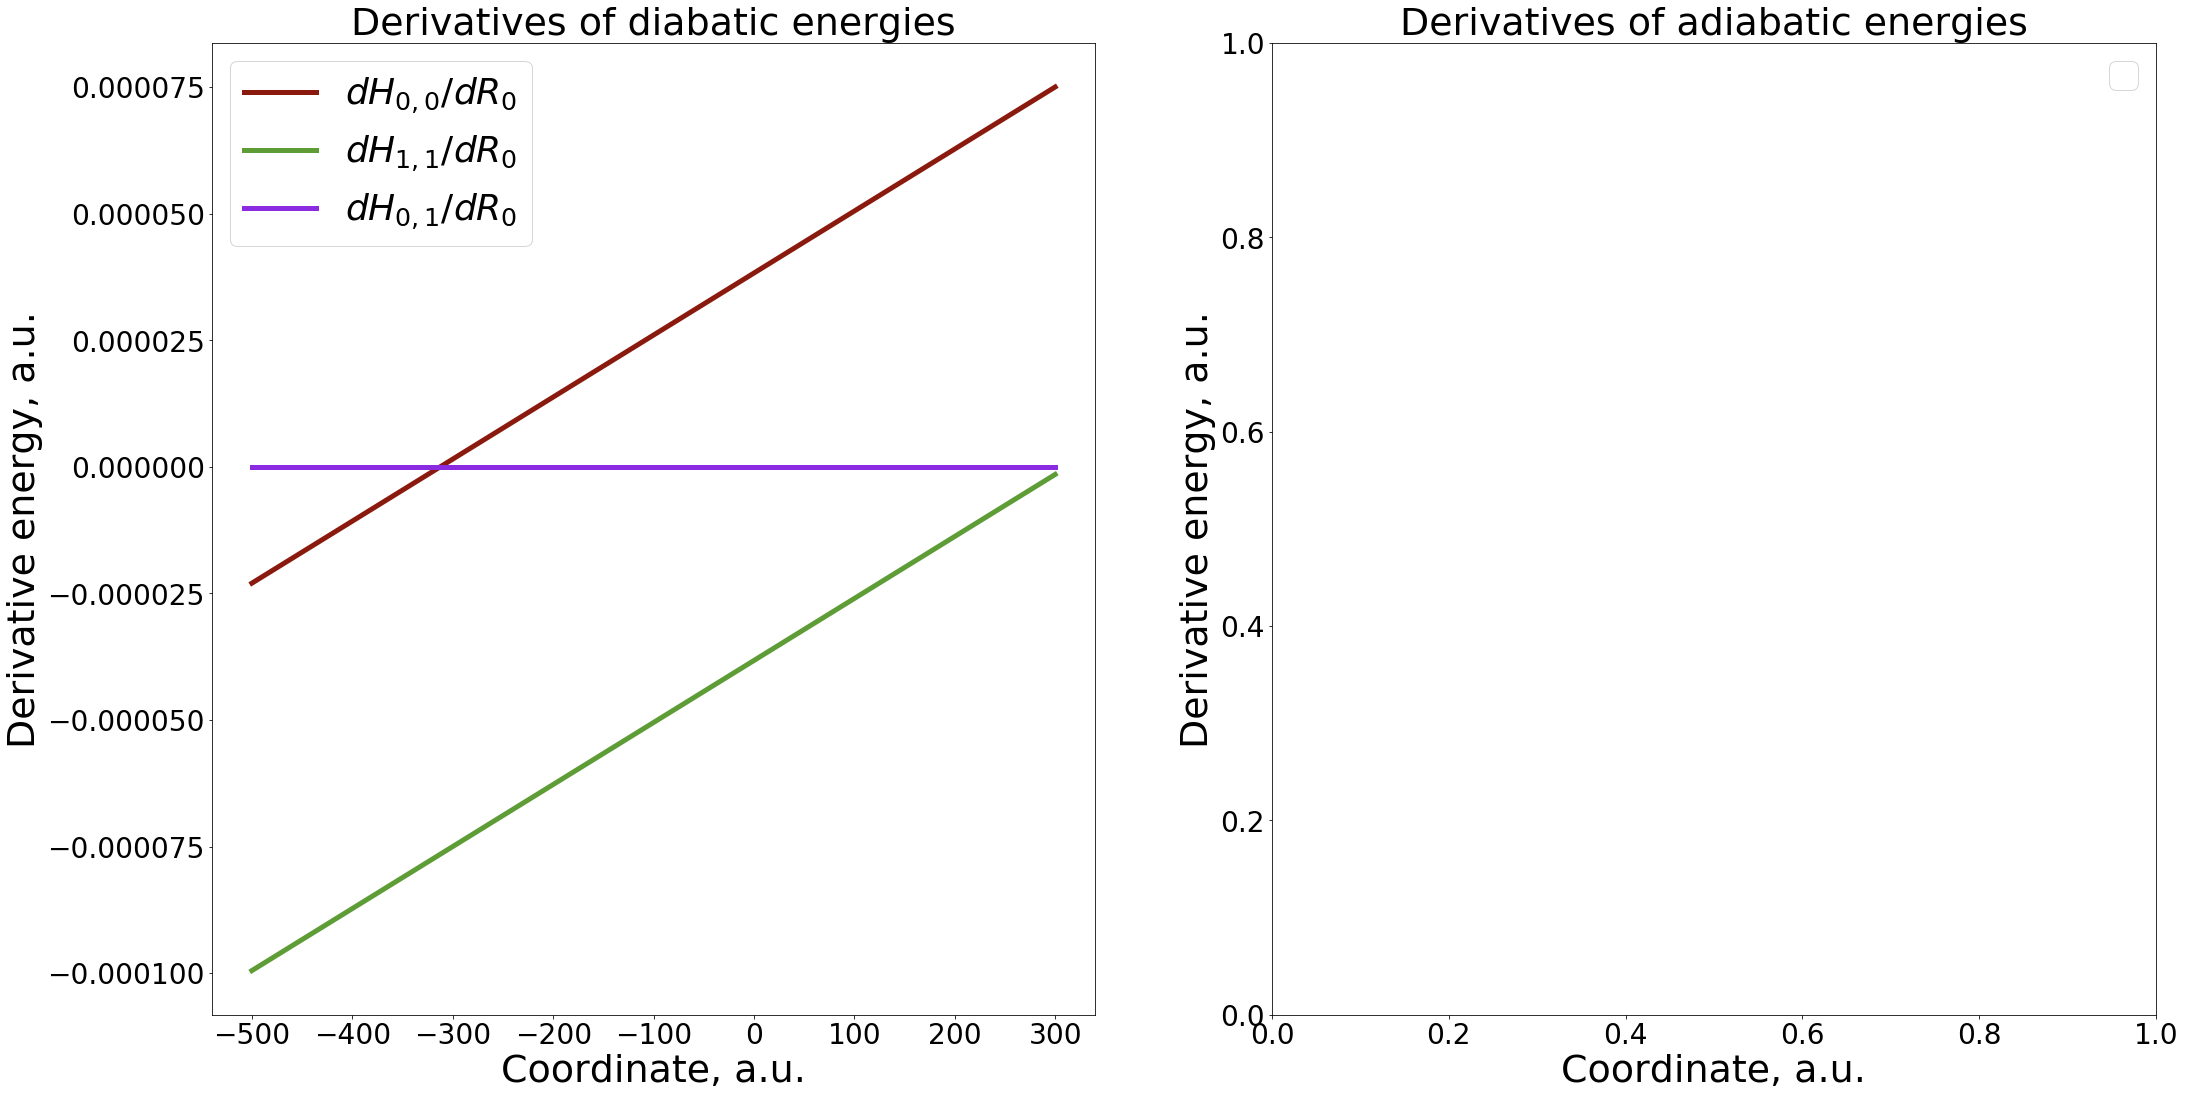

No handles with labels found to put in legend.


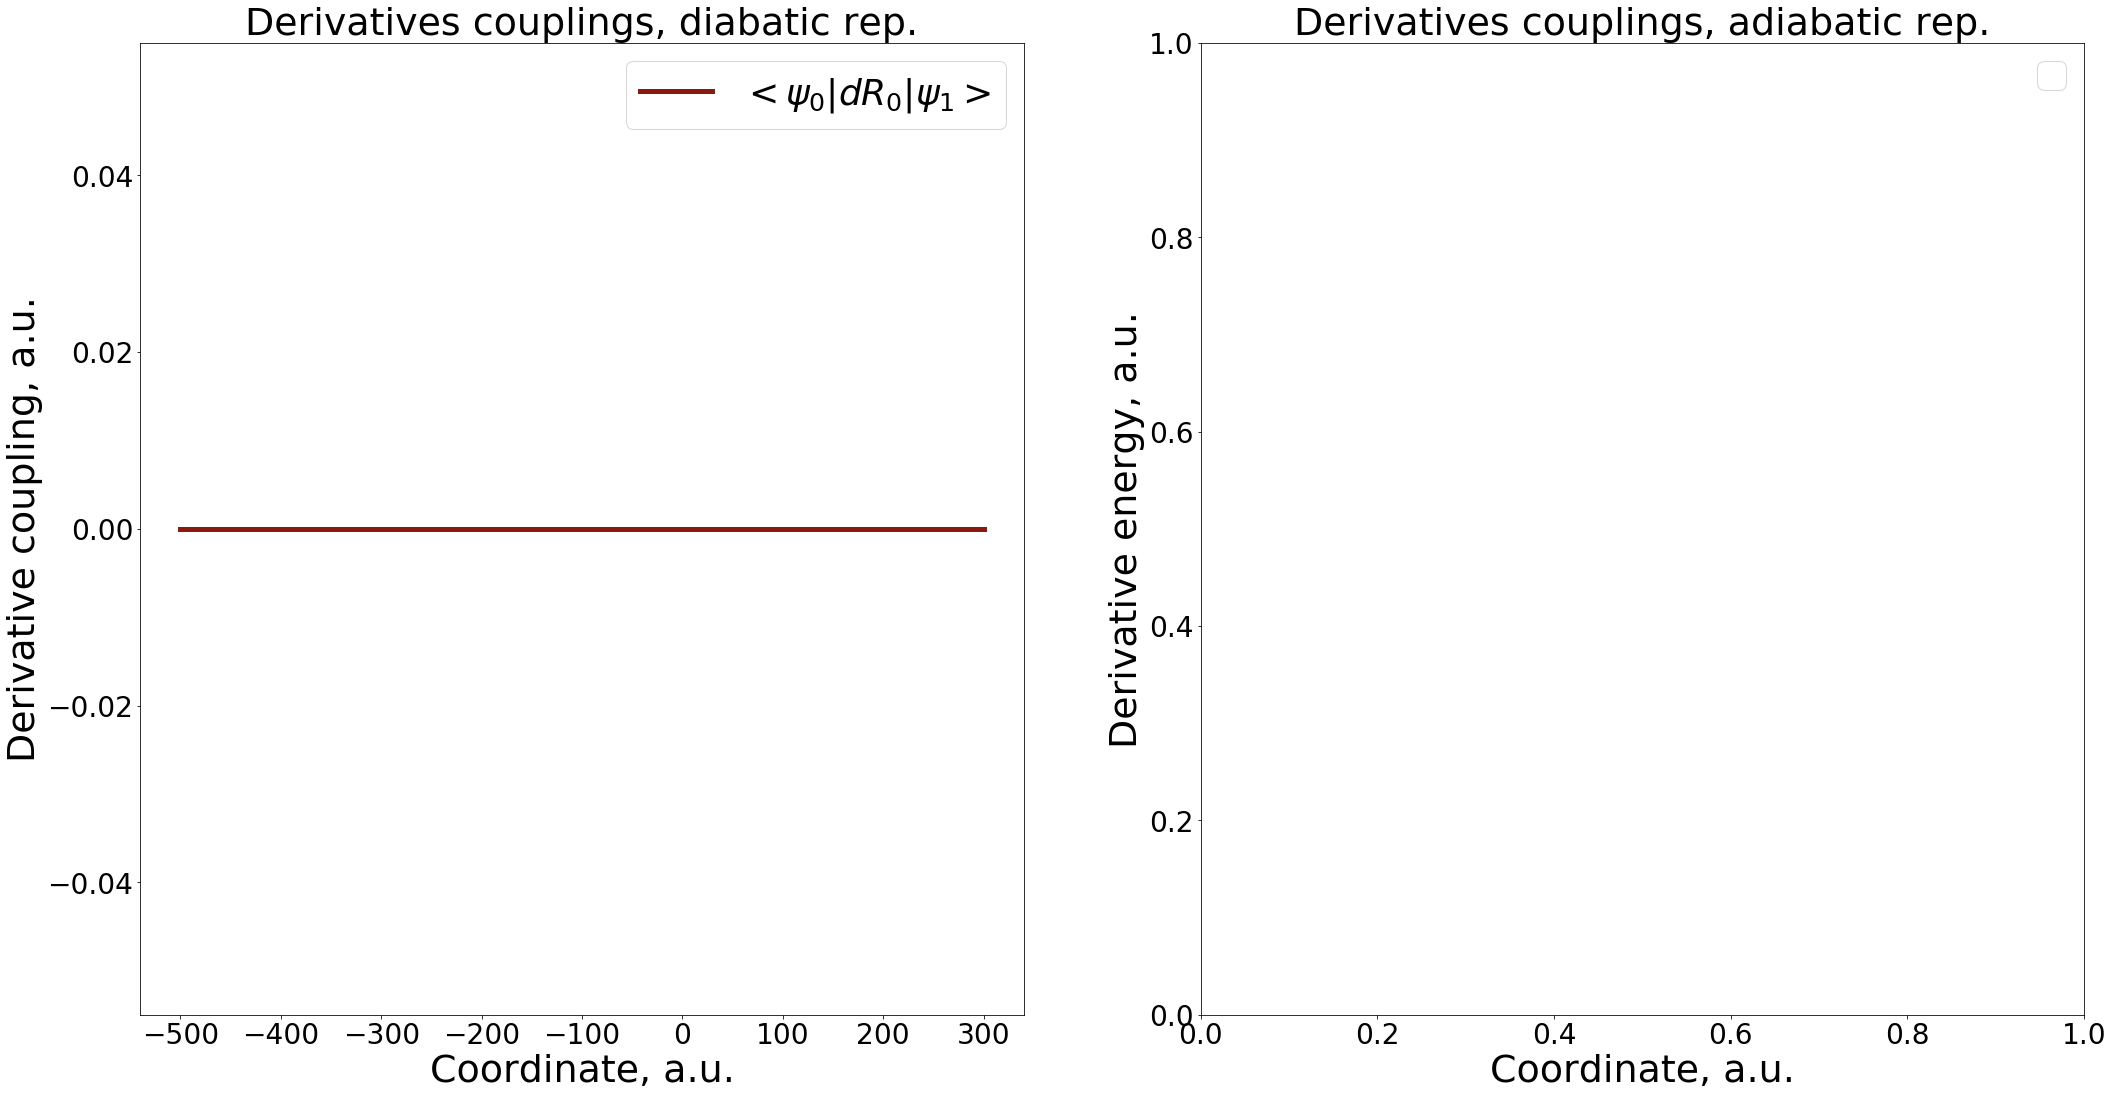

In [7]:
pes_params = { "ndia":2, "nadi":2, "ndof":1,
               "xmin":-500.0, "xmax":300.0, "dx":1.0,
               "rep_tdse":0, "rep_ham":0  }

plot_params = { "which_ham_dia":[ [0,0], [1,1], [0,1] ],
                "which_d1ham_dia":[ [0, 0,0], [0, 1,1], [0, 0,1] ],
                "which_dc1_dia":[ [0, 0,1] ],
                "colors": colors, "clrs_index": clrs_index
              }

dynamics_plotting.plot_pes_properties(compute_model, {"model":1}, pes_params, plot_params )

### Exercise 5

* Define your own color palette and plot the Hamiltonian properties in different colors

* Define your own color mapping scheme and plot the Hamiltonian properties in different colors

### Exercise 6

For the 3-level Hamiltonian defined in Exercise 1, plot all the important non-redundant properties.

[Back to TOC](#TOC)

There is another similar-in-spirit function that you can use - `plot_surfaces` also defined in the `libra_py.dynamics_plotting` module.

This function:

* doesn't plot the derivatives of the Hamiltonians;
* doesn't plot the derivative couplings;
* doesn't plot the off-diagonal matrix elements of the Hamiltonians - only the diagonal matrix elements of the Hamiltonians (in both representations);

However: 

* it does the adiabatization (so **only works when the diabatic matrix elements are defined!**);
* it plots the projections of the adiabatic states specified in the input as the third parameter (here, `[0, 1]`) on all of the diabatic states. So, in the example below, we want to see the projections of all our adiabatic states - 0 and 1.
* it can do such a plotting for a range of model potentials - note how the second arument to the `plot_surfaces` function goes as a list of 1 entry,  `[ model_params ]` instead of just `model_params`. So, you can add another parameters set and see more pictures printed out. 
  
  IMPORTANT: each model parameters sets (a Python dictionary) should have the `nstates` parameter specified. 
  
<a name="1d_pes_plotting2-ex1"></a>
<a name="plot_surfaces-ex1"></a>     

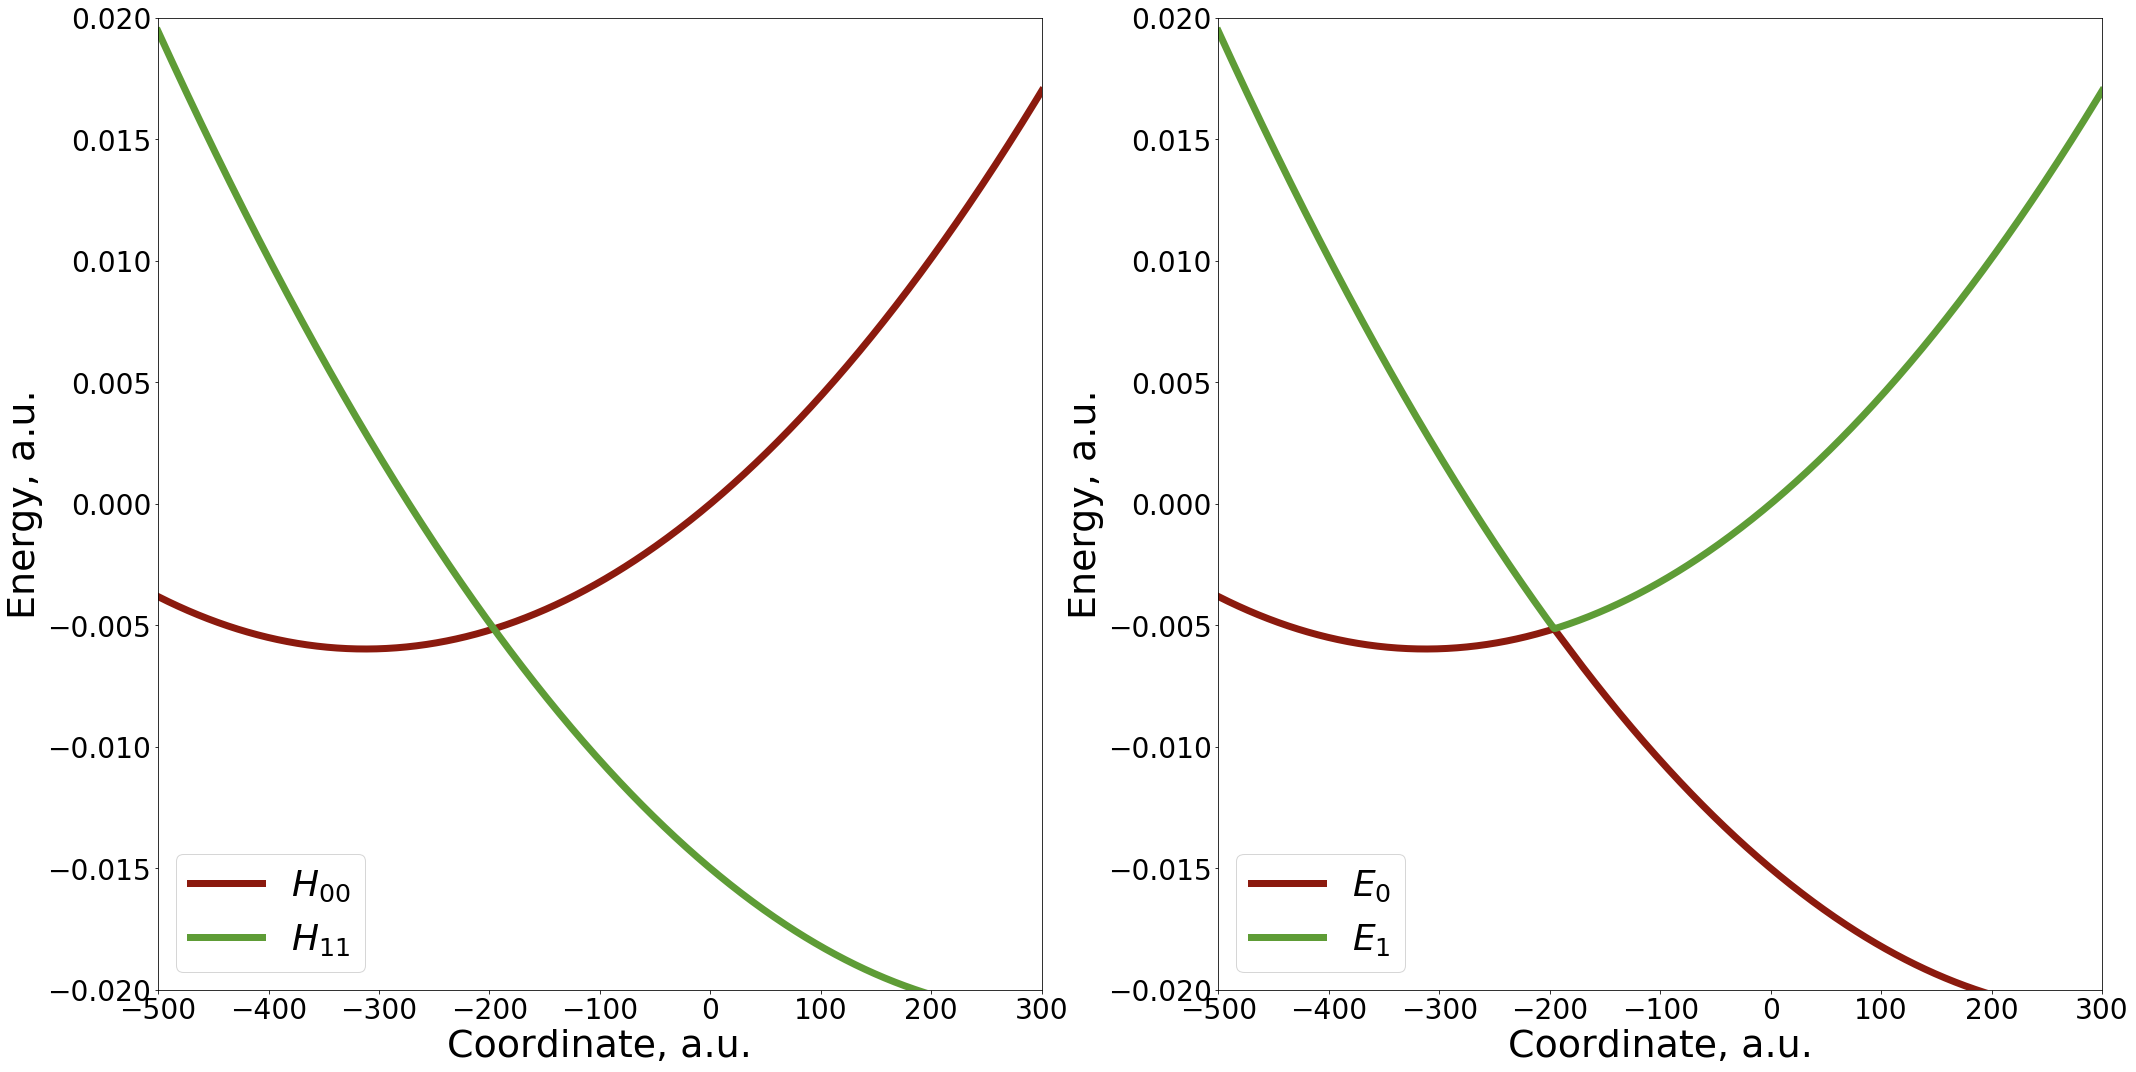

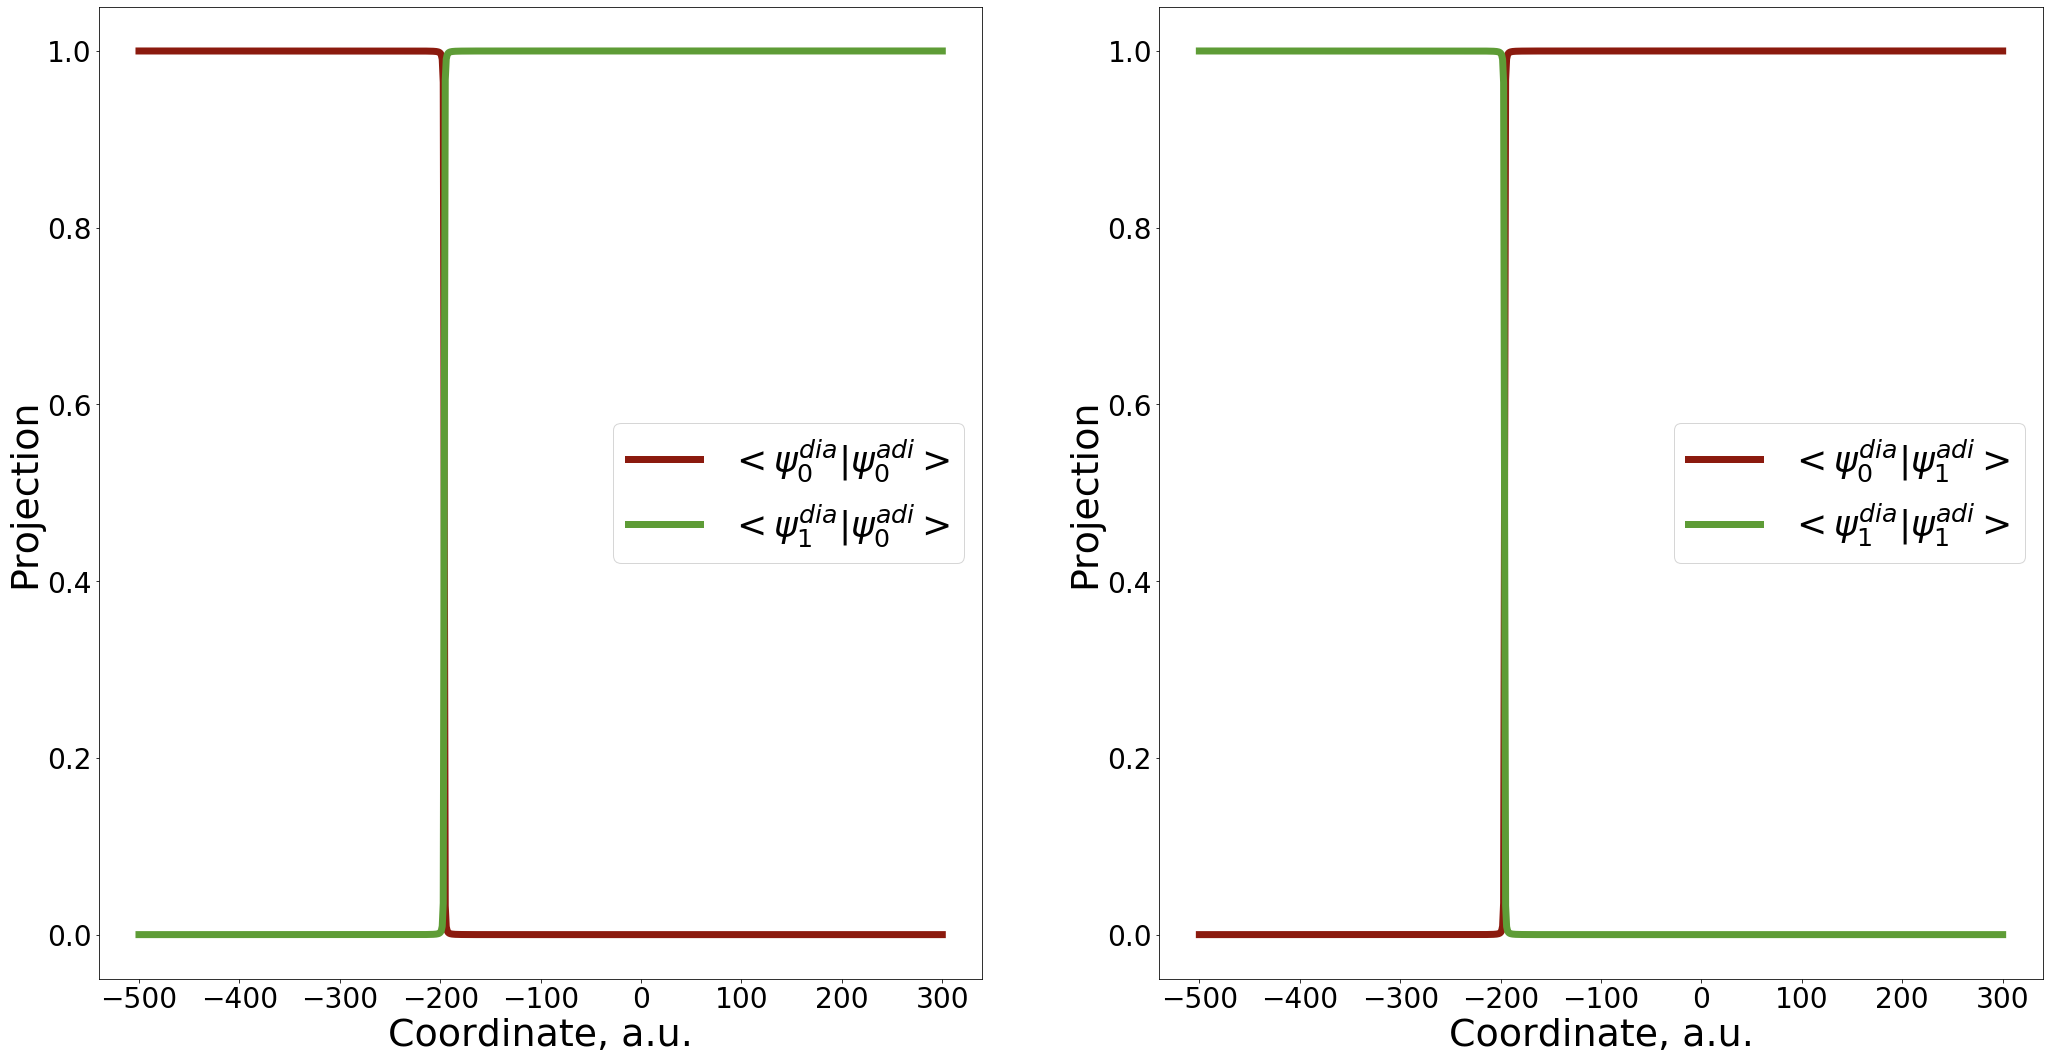

In [8]:
model_params = { "nstates":2, "model":1}  
plot_params = {"colors": colors, "clrs_index": clrs_index, "ylim":[-0.02, 0.02], "xlim":[-500.0, 300.0]}
dynamics_plotting.plot_surfaces(compute_model, [ model_params ], [0,1], -500, 300.0, 1.0, plot_params)

Here, is how the multiple parameters set plotting works:

<a name="1d_pes_plotting2-ex2"></a>
<a name="plot_surfaces-ex2"></a>     

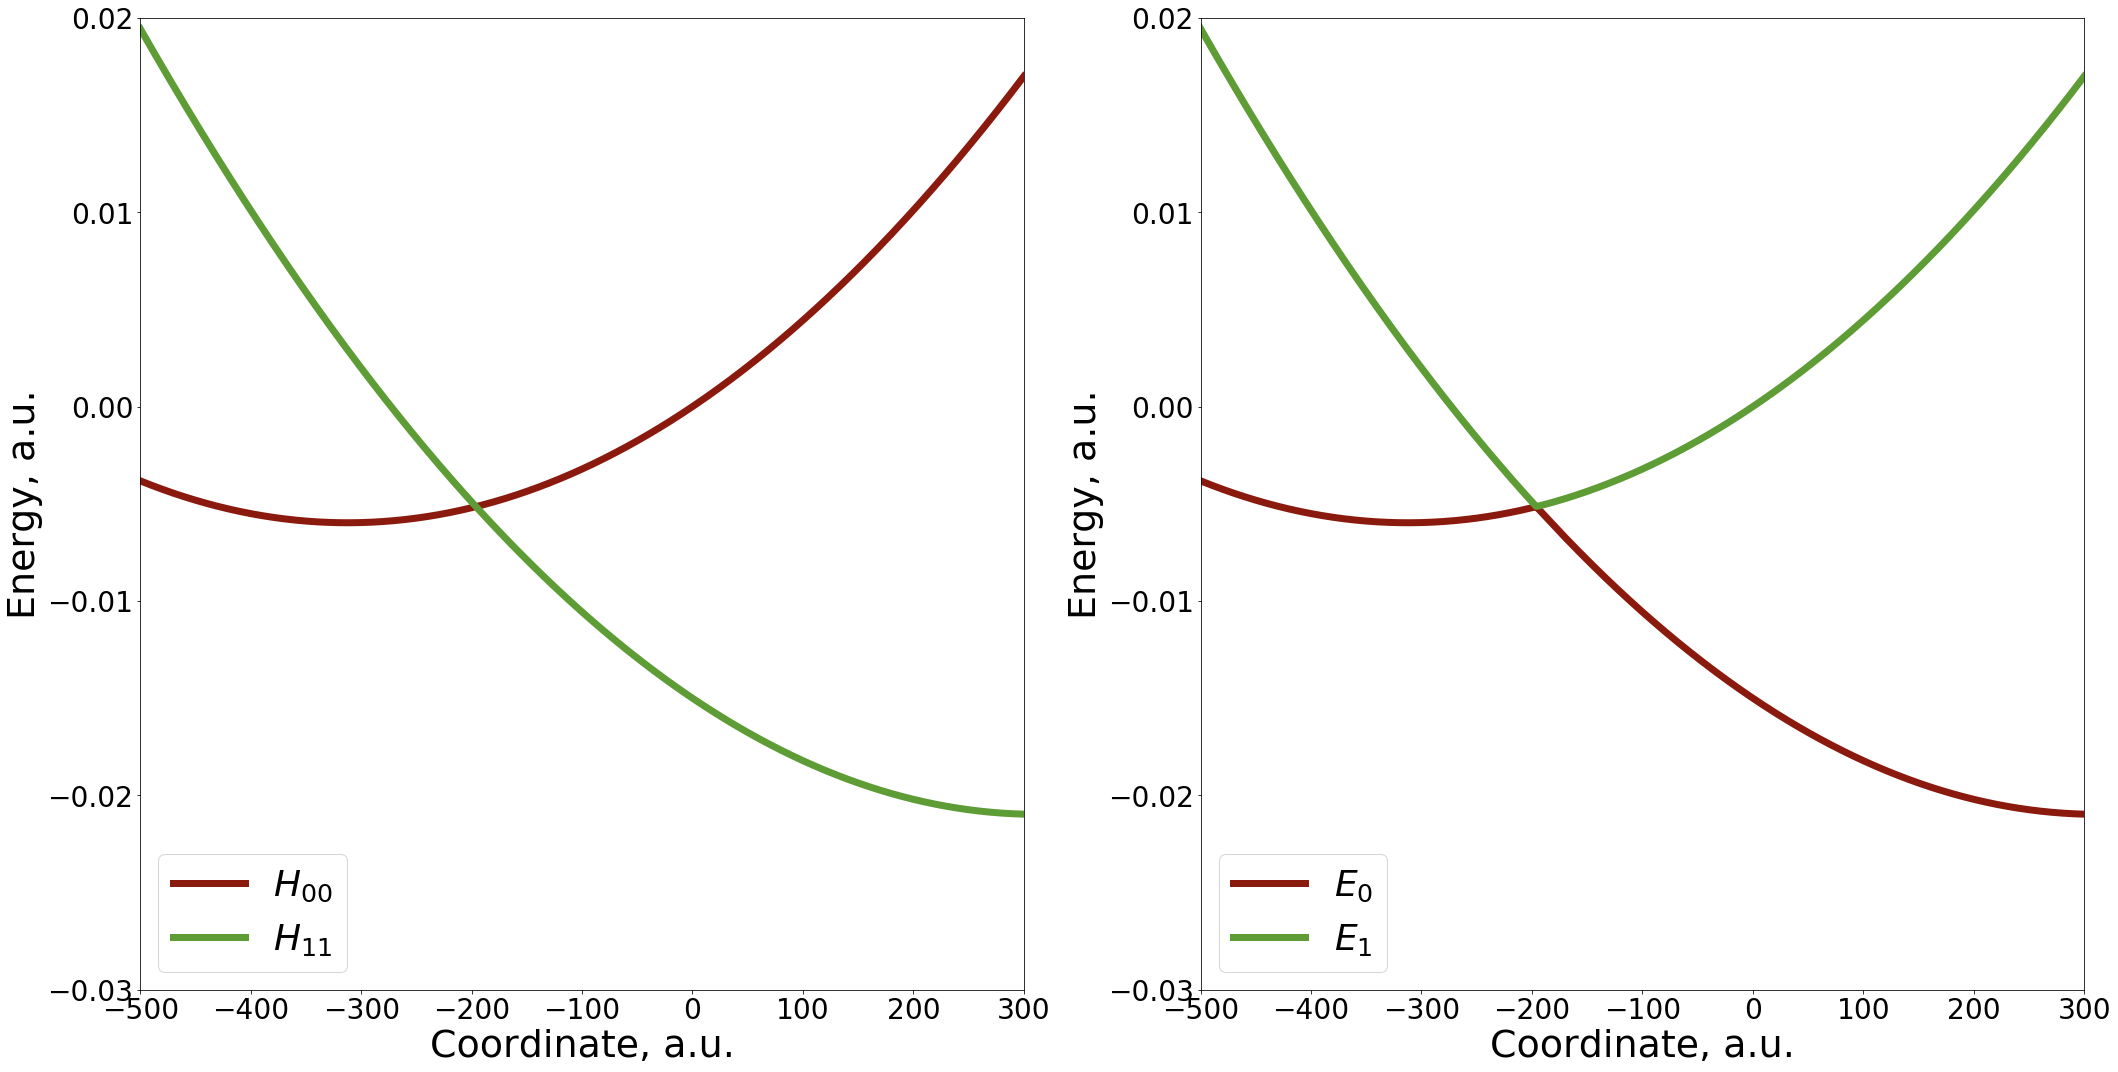

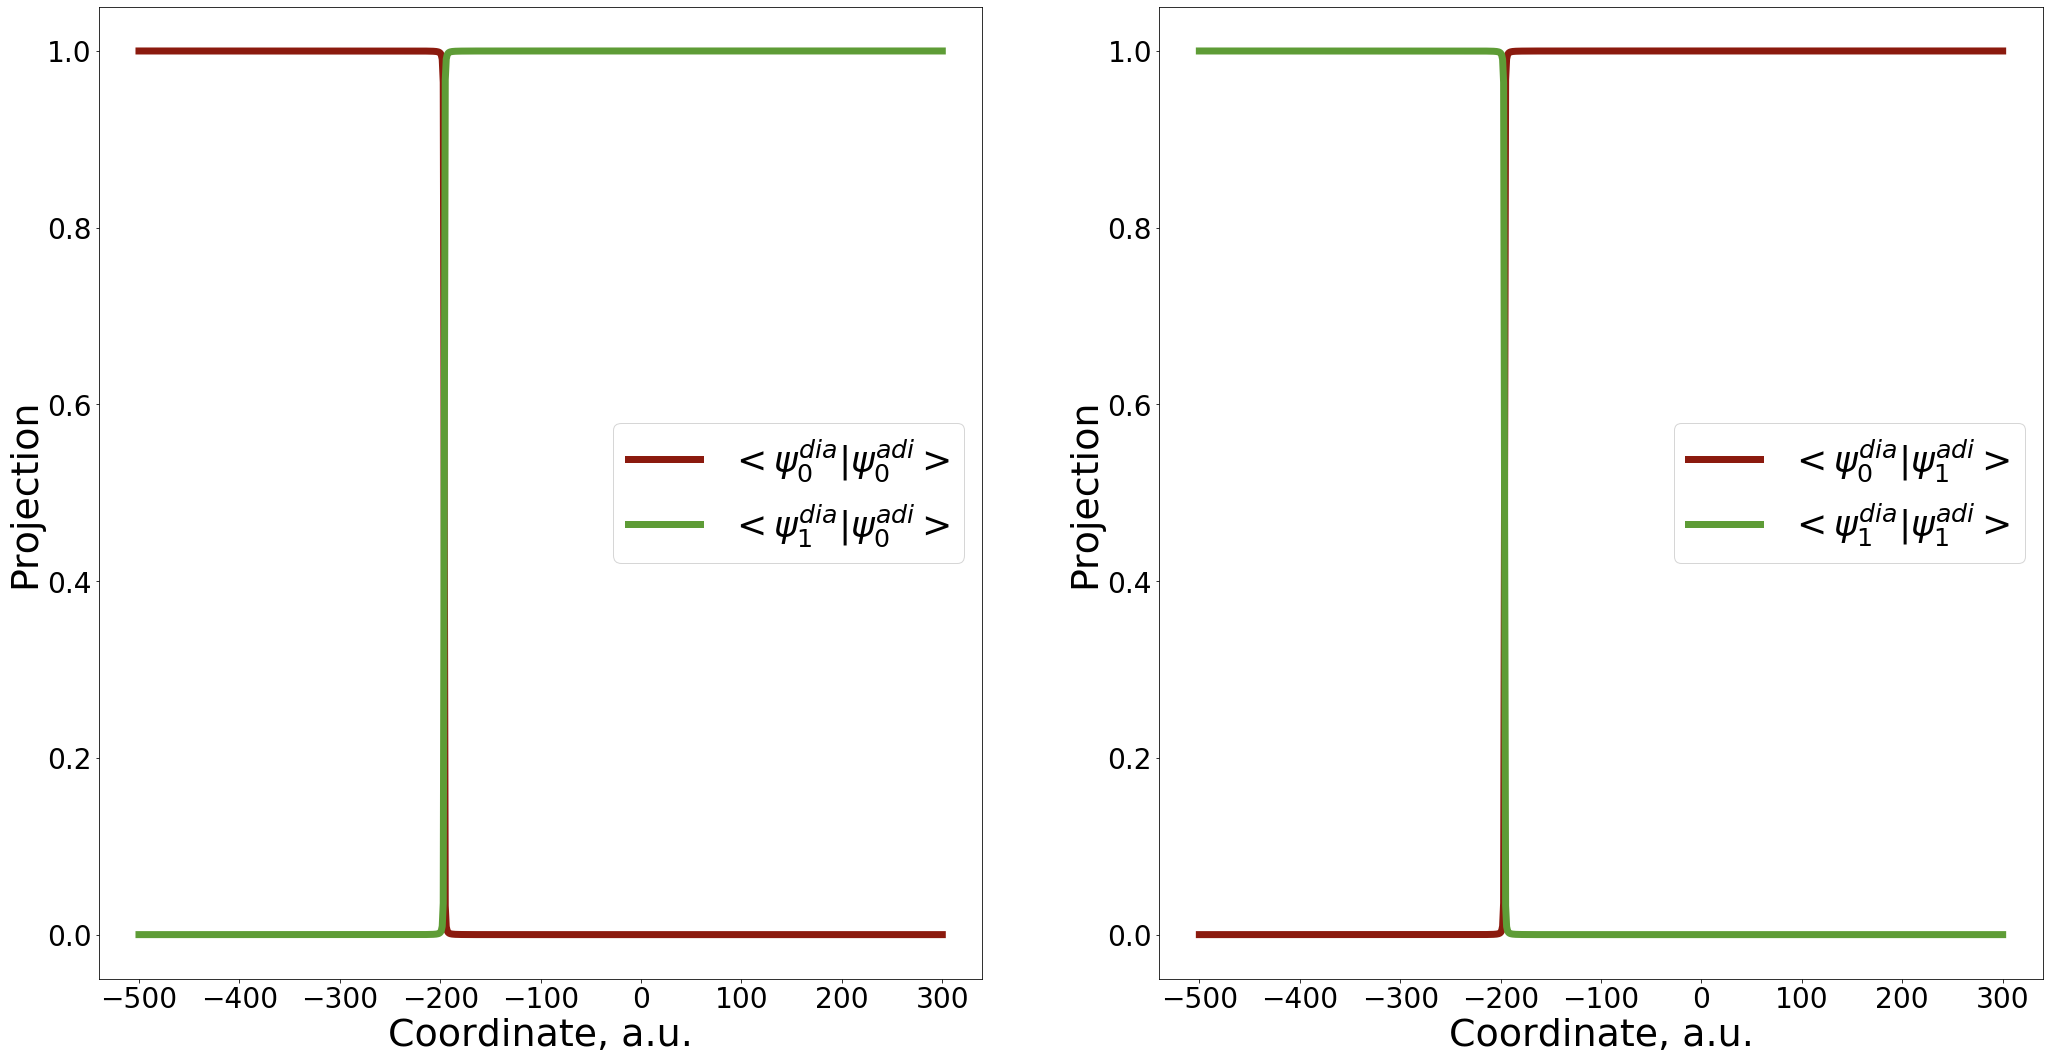

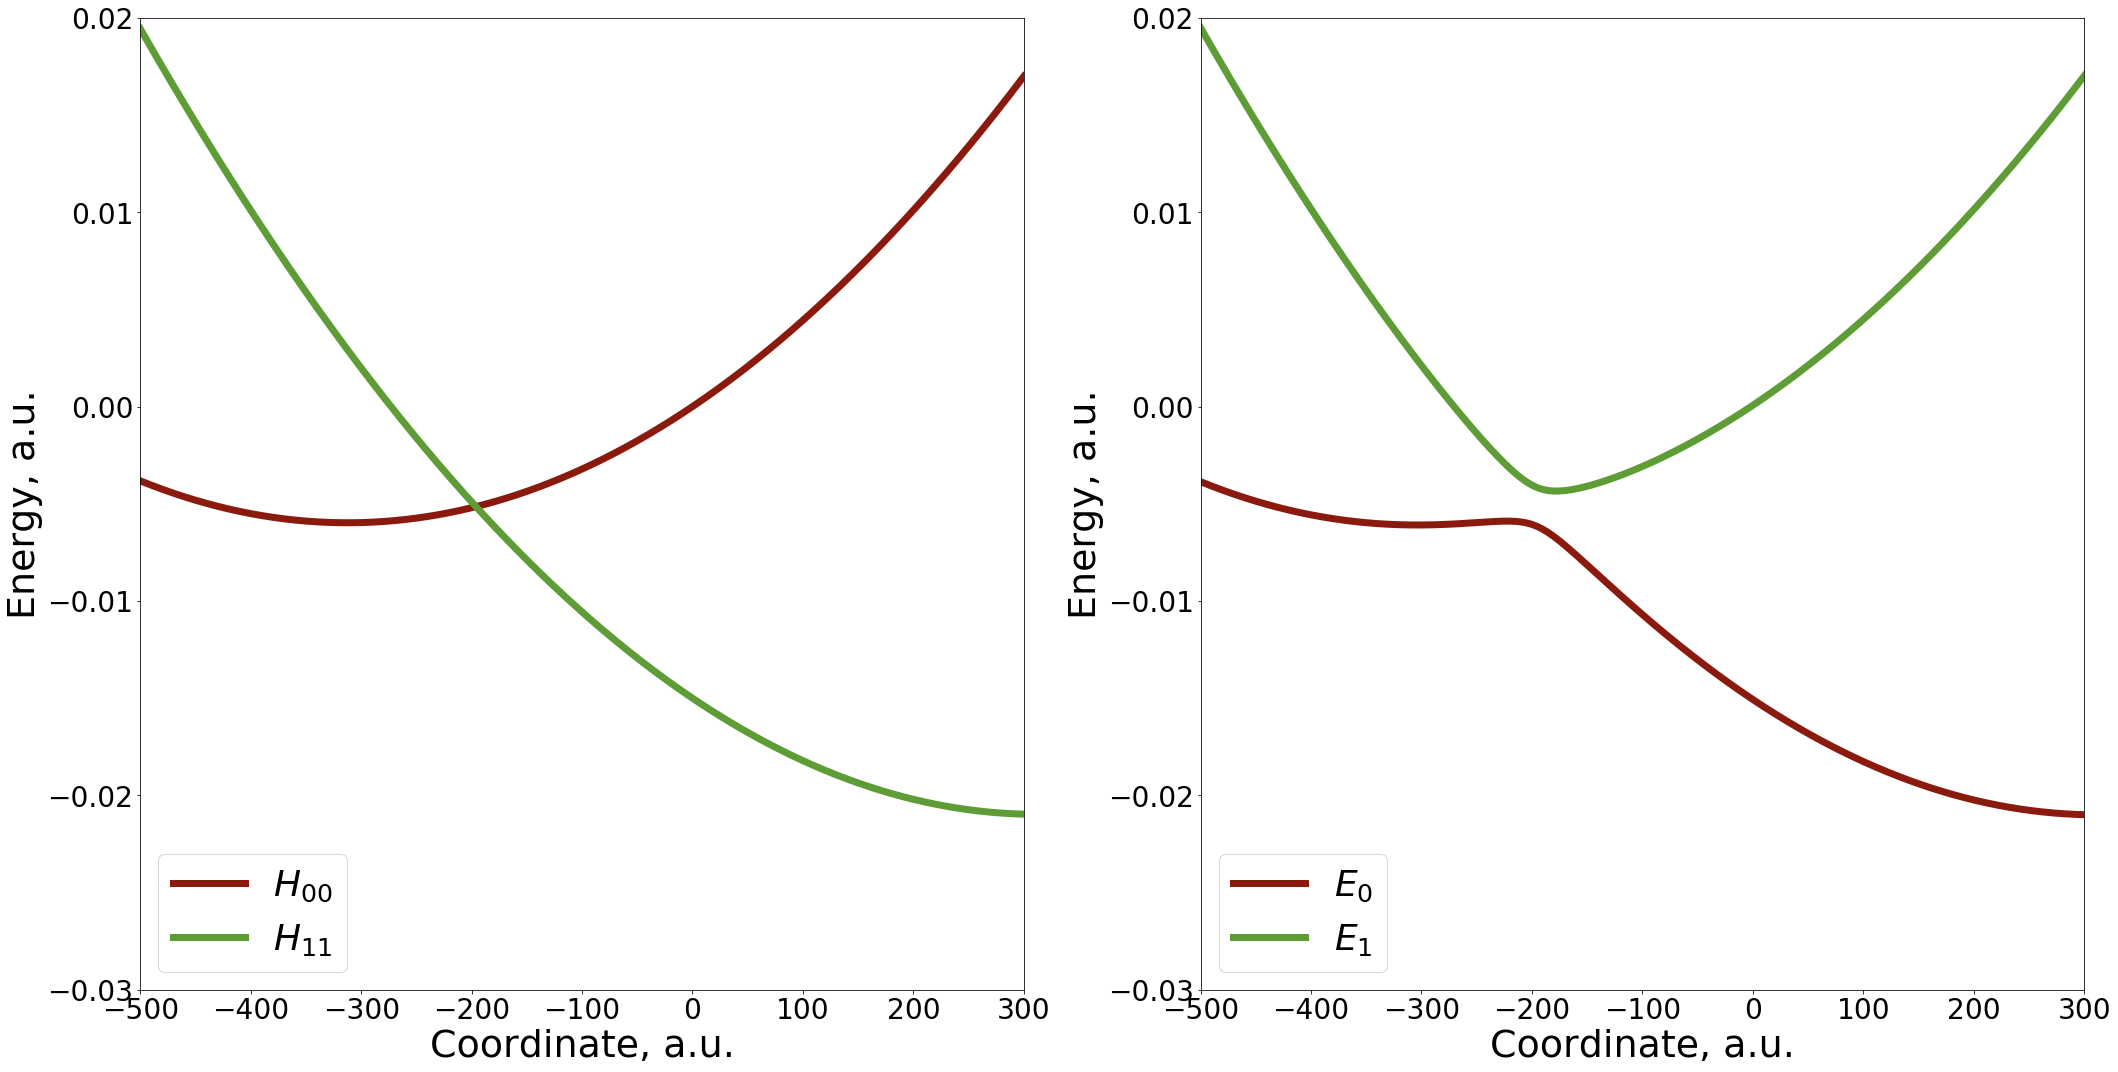

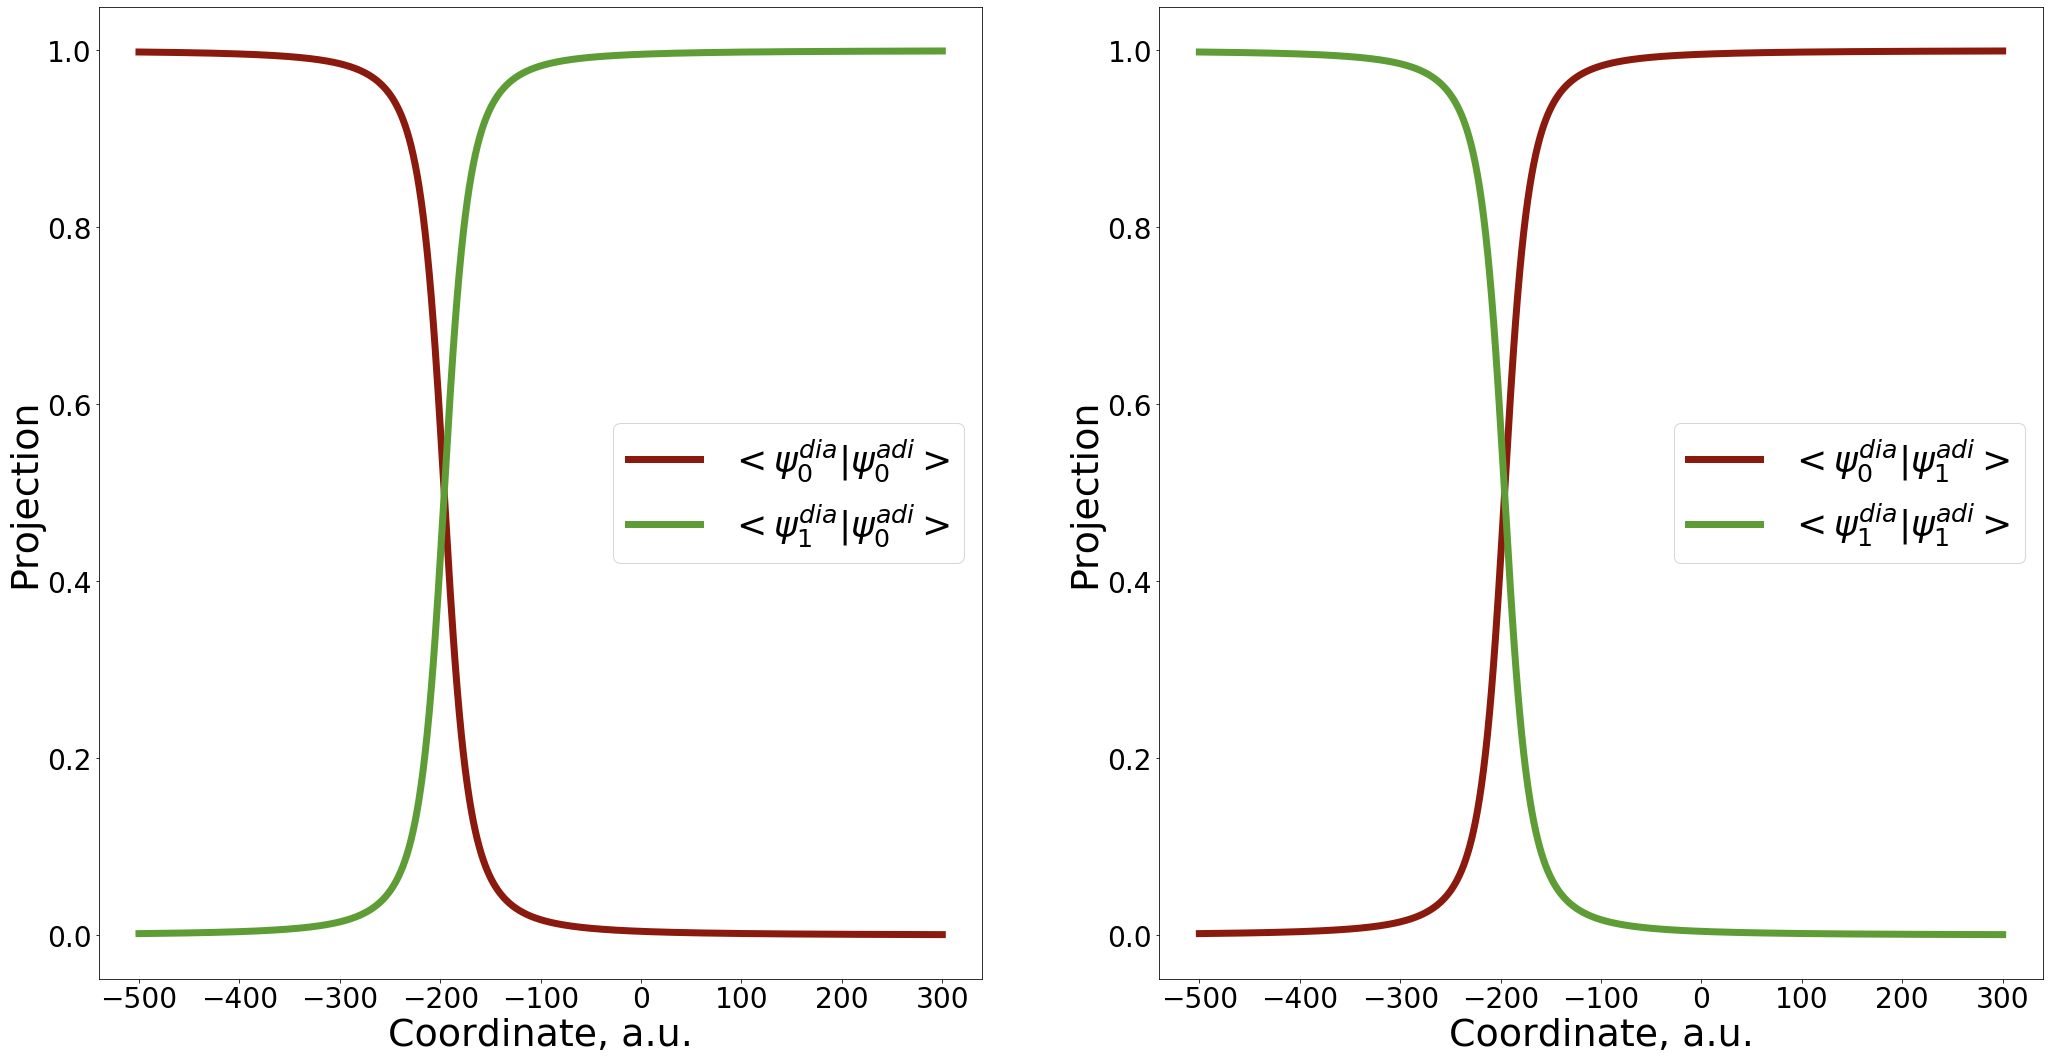

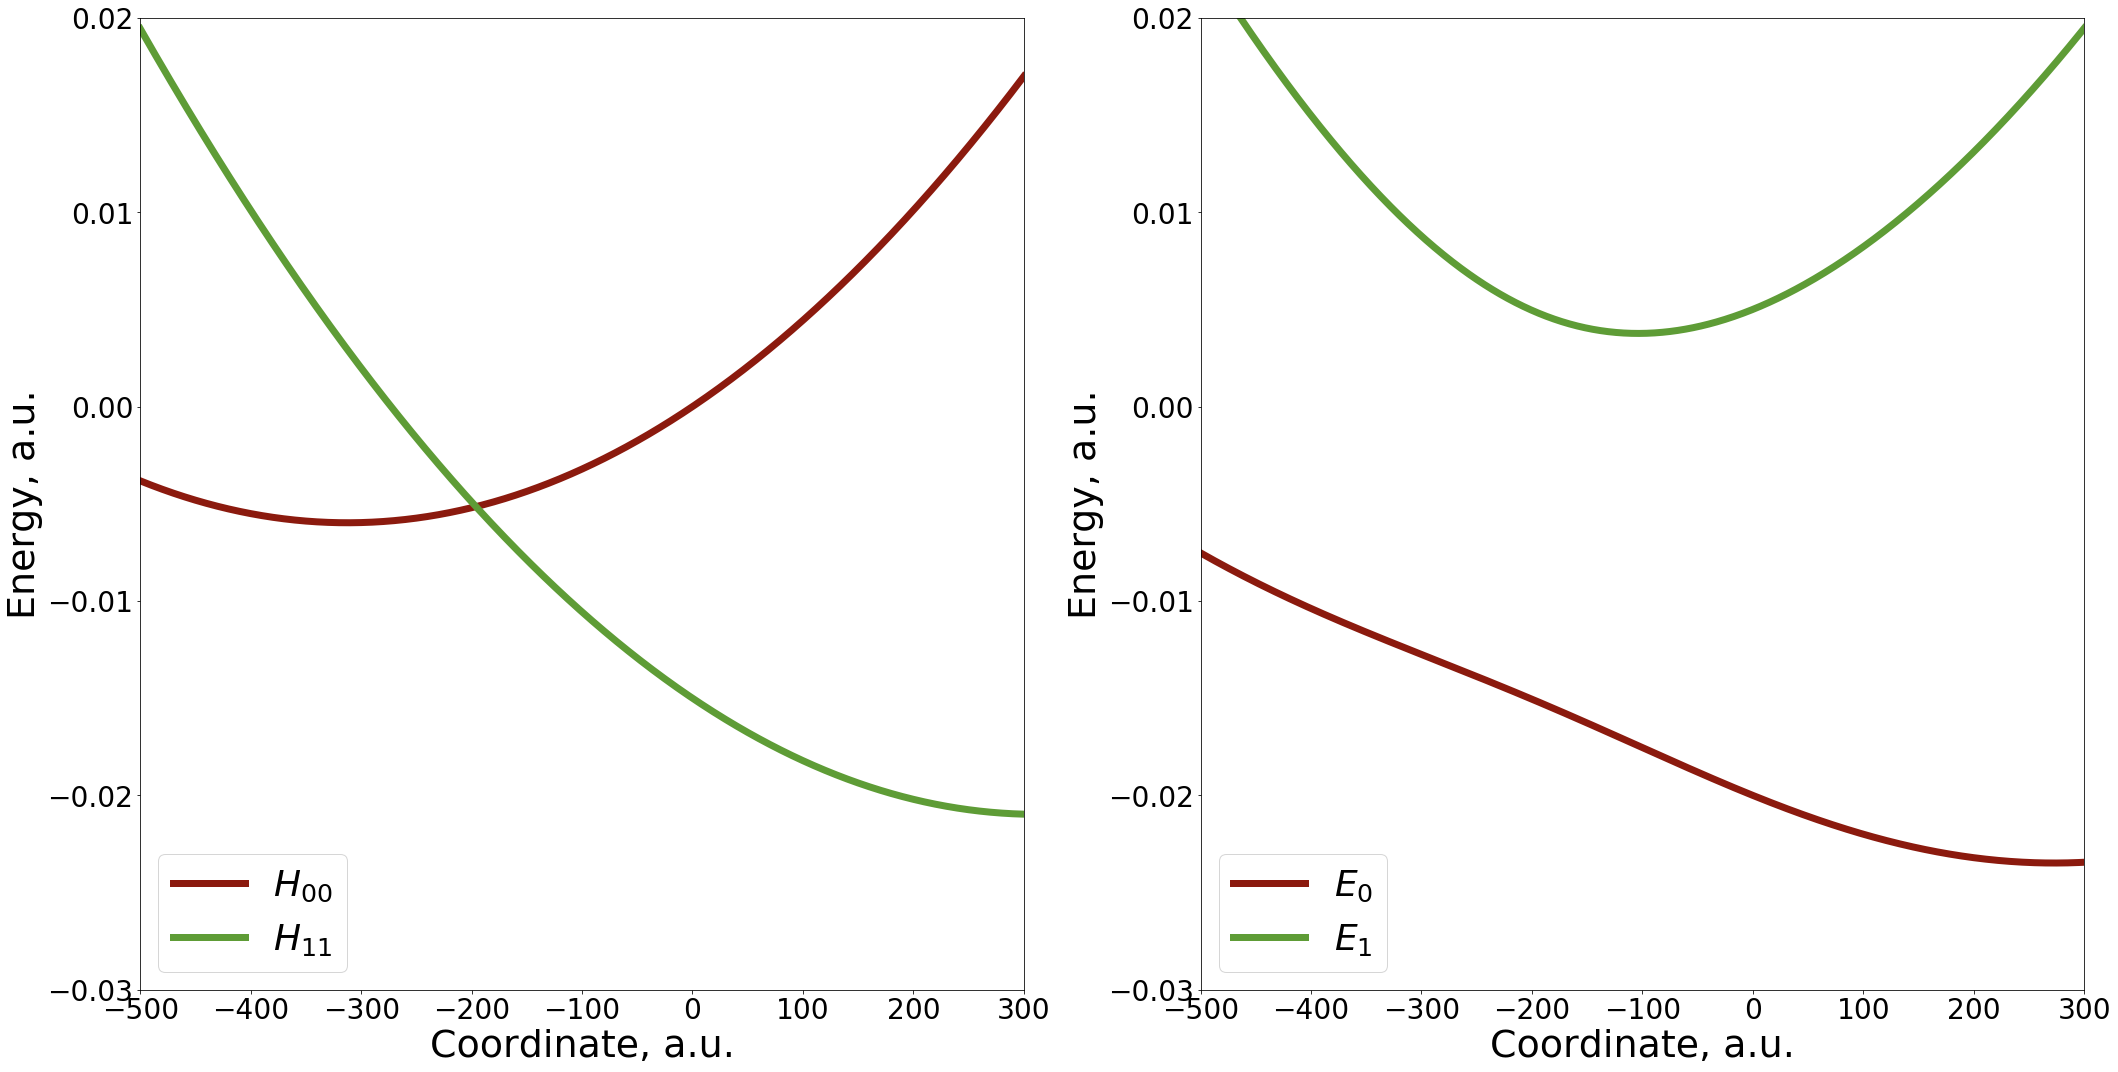

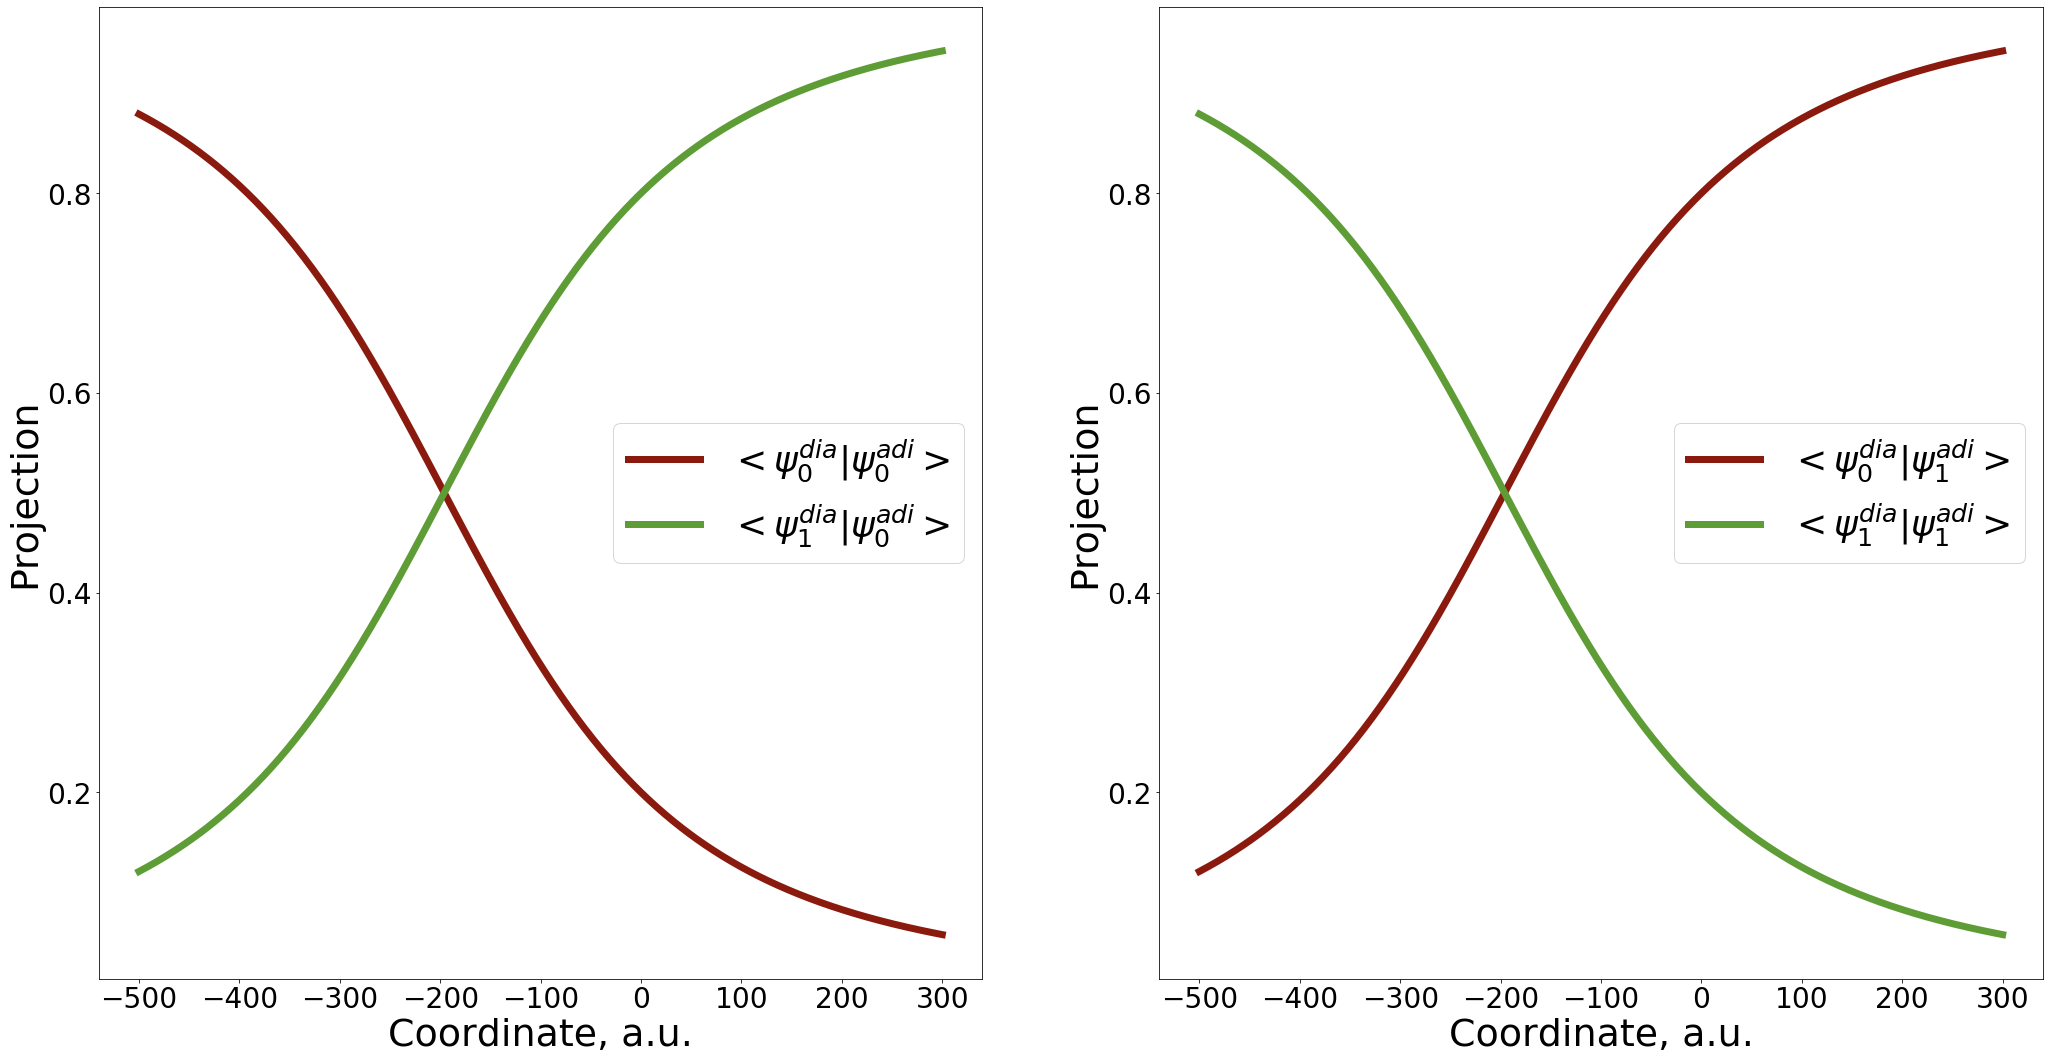

In [9]:
model_params_set1 = { "nstates":2, "model":1}  # default value of V = 1.49e-5 is used
model_params_set2 = { "nstates":2, "model":1, "V":1e-3 }  
model_params_set3 = { "nstates":2, "model":1, "V":1e-2 }  

               
plot_params = {"colors": colors, "clrs_index": clrs_index, "ylim":[-0.03, 0.02], "xlim":[-500.0, 300.0]}
dynamics_plotting.plot_surfaces(compute_model, 
                                [ model_params_set1, model_params_set2, model_params_set3], 
                                [0,1], -500, 300.0, 1.0, plot_params)

<a name="pes_scan-2"></a>
[Back to TOC](#TOC)

### 2.2. Option 2: Adiabatic properties via numerical adiabatization
Now, we want adiabatic properties but the model returns only the diabatic properties, so the needed calculations will be done under the hood

<a name="1d_pes_plotting1-ex2"></a>
<a name="plot_pes_properties-ex2"></a>

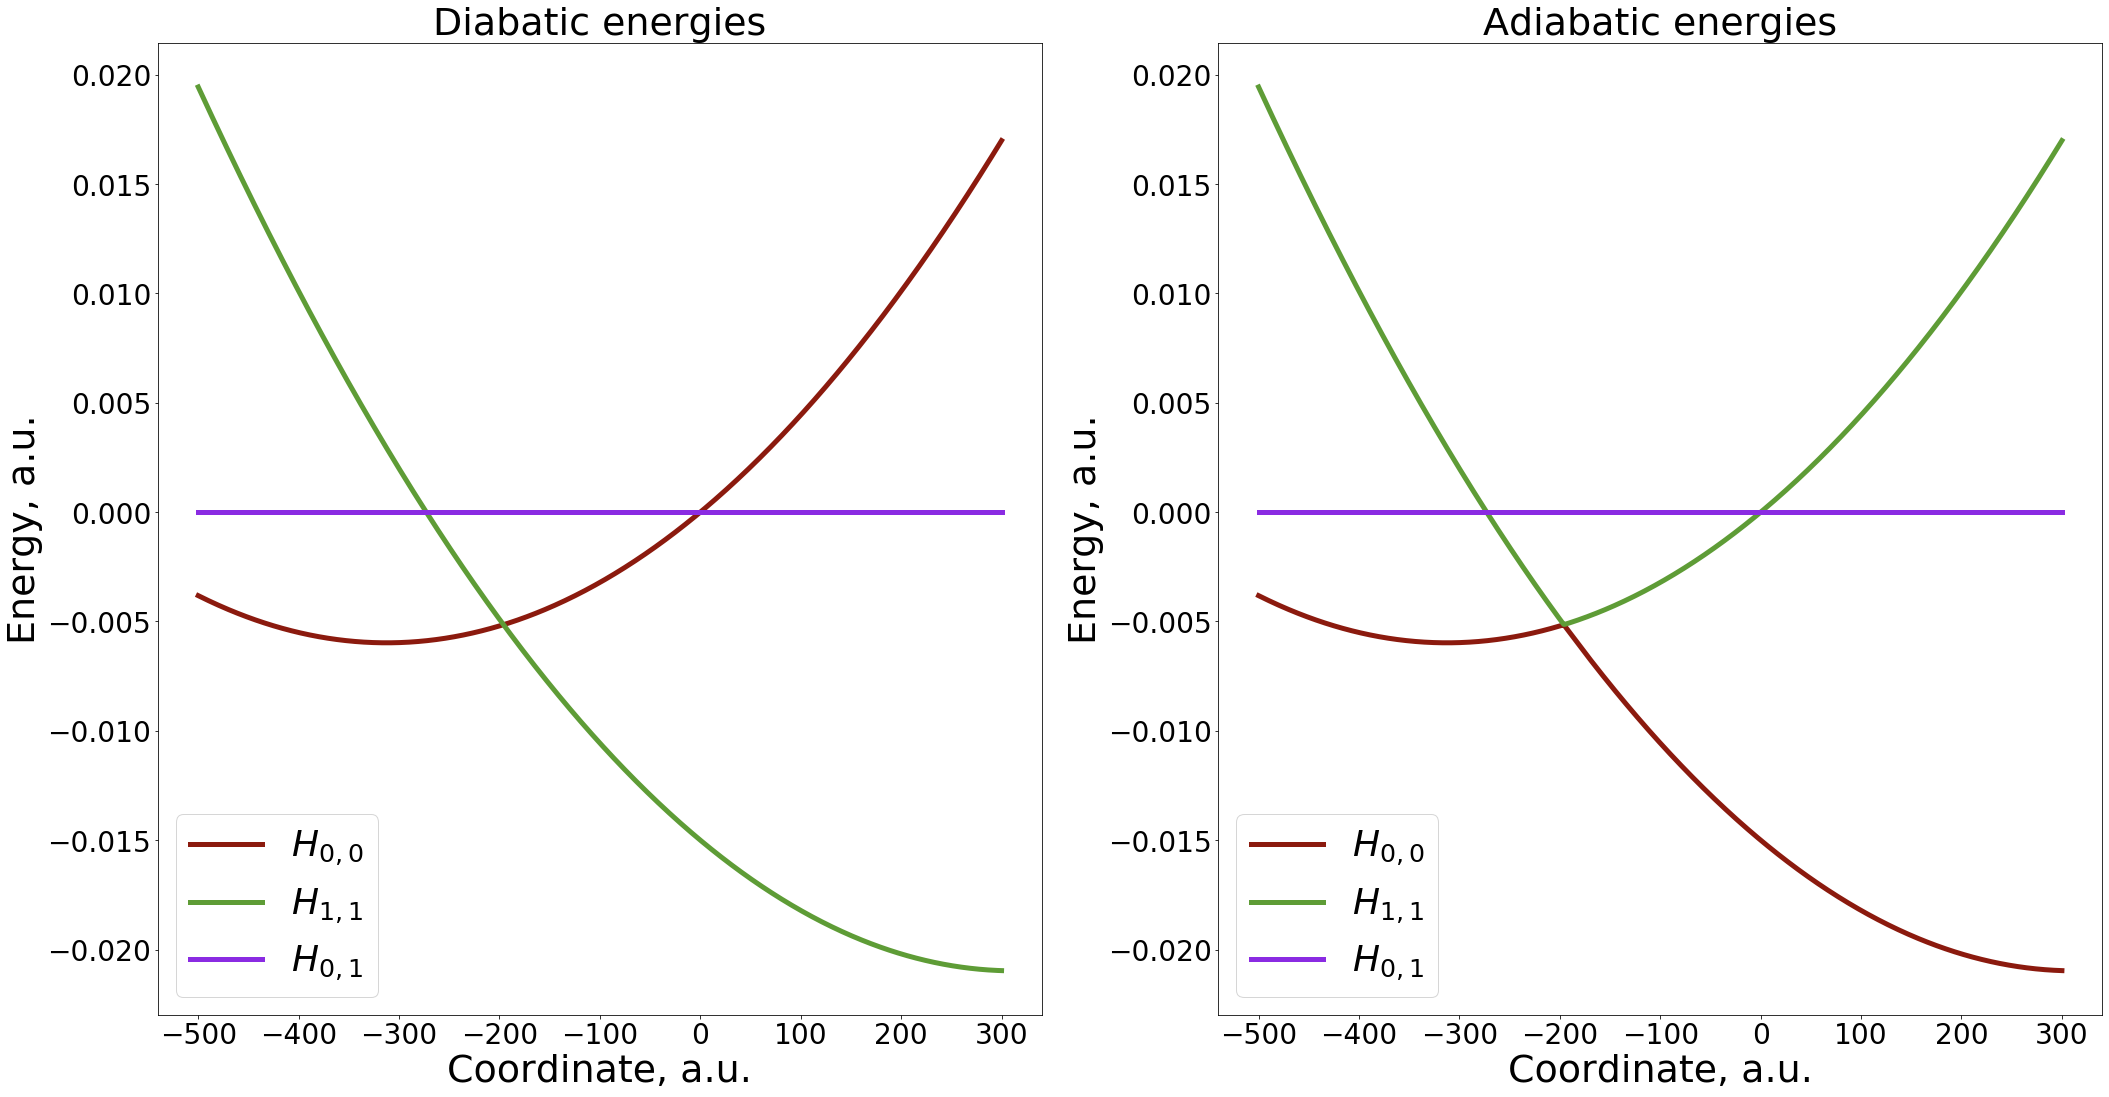

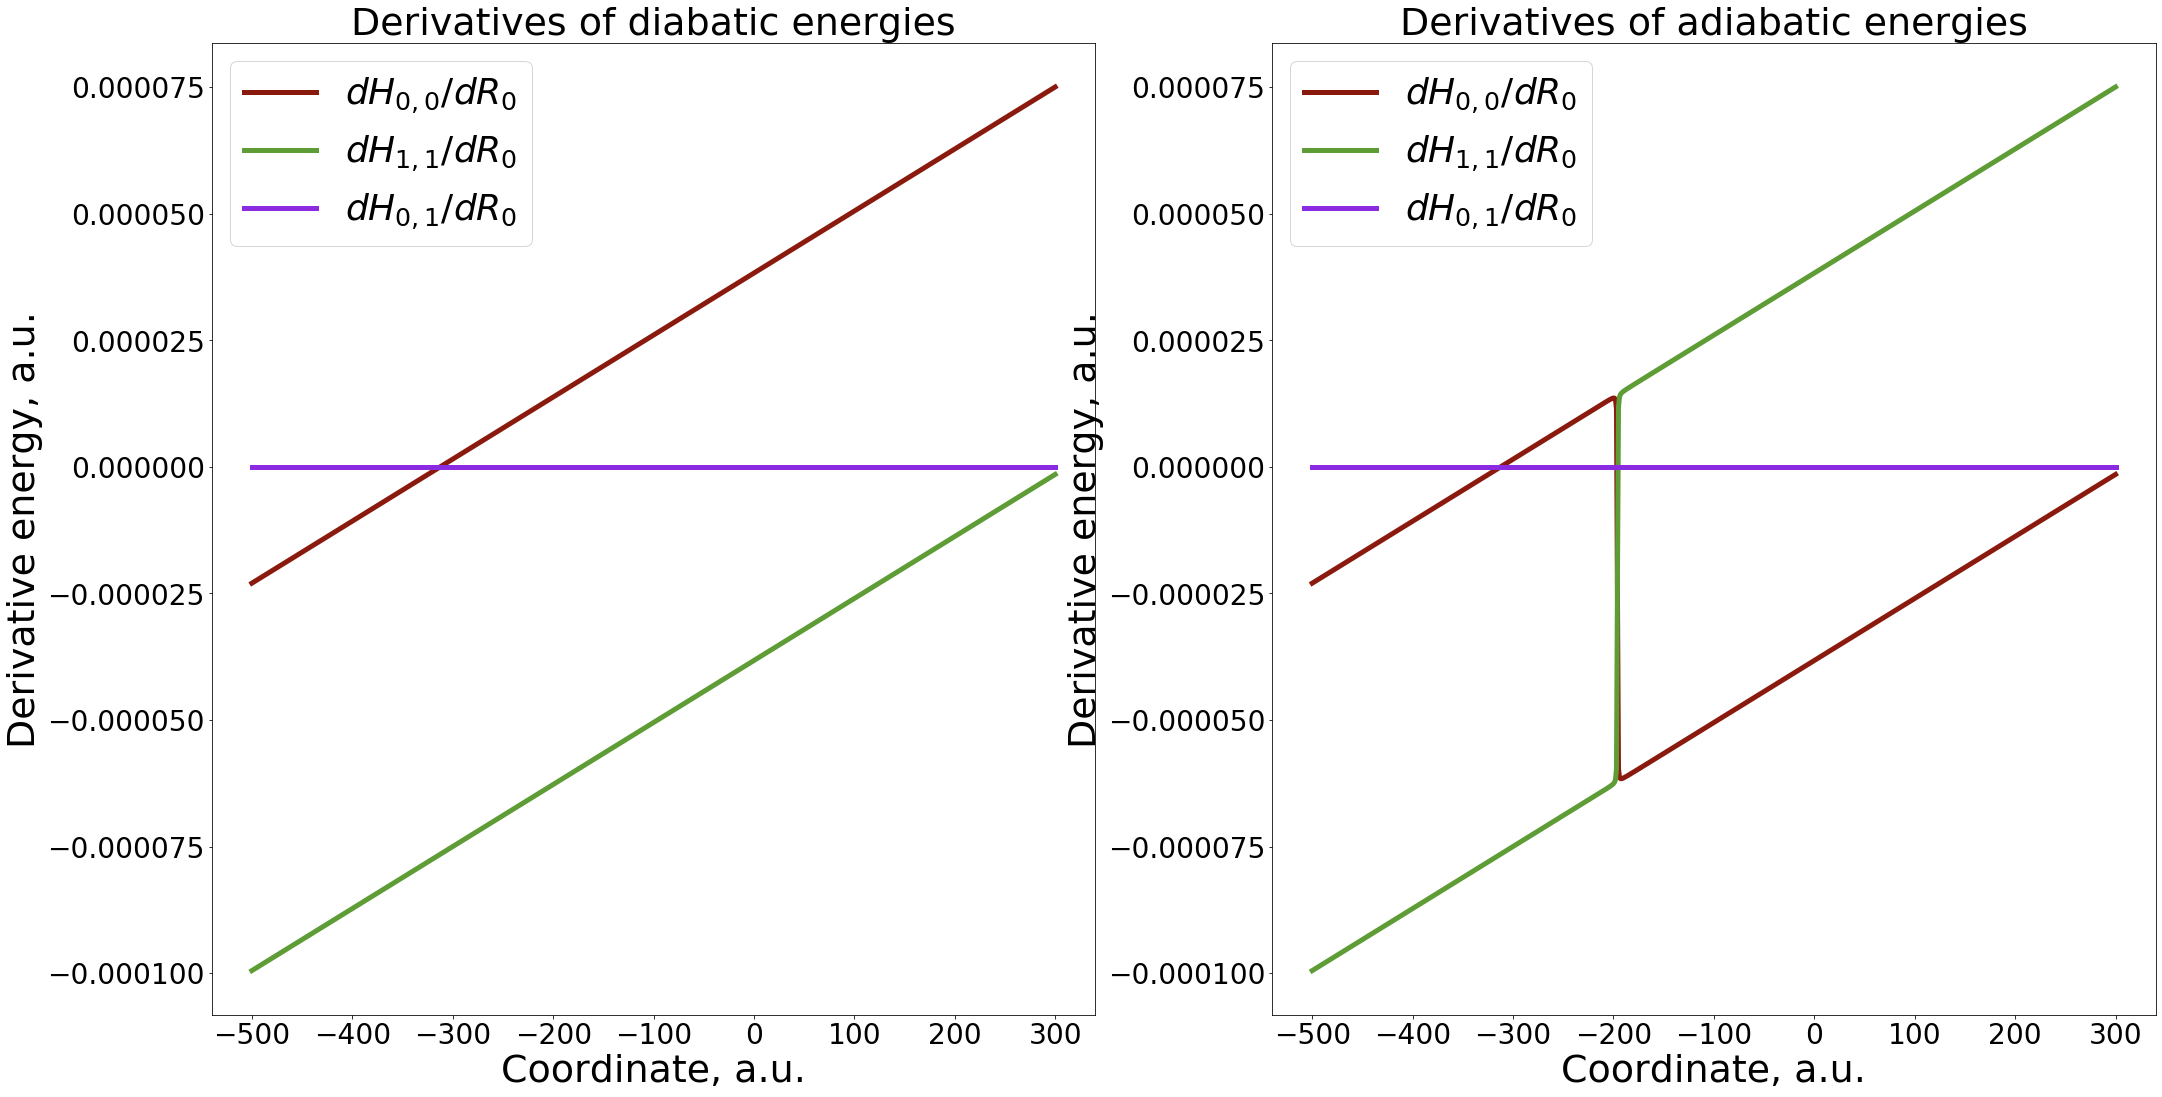

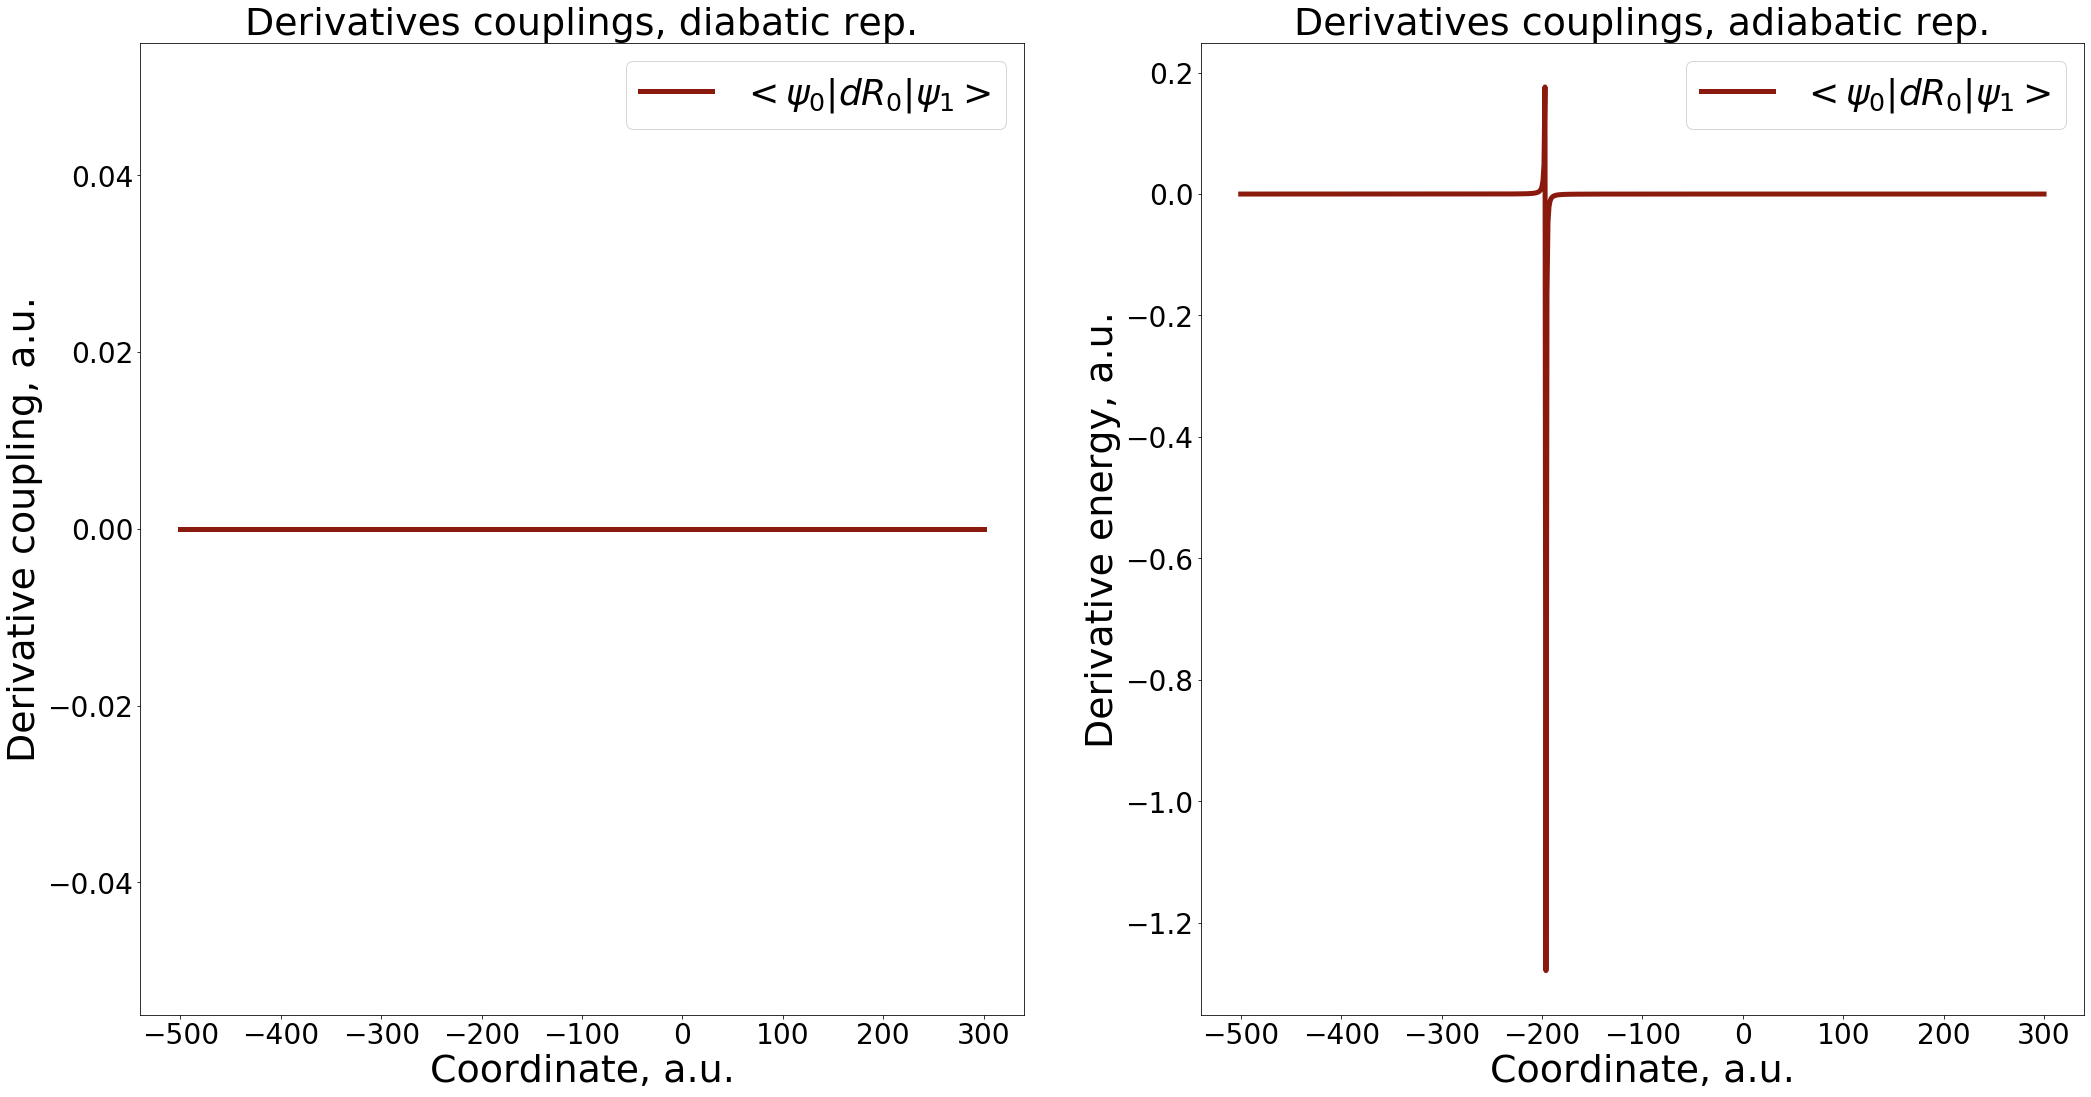

In [10]:
pes_params = { "ndia":2, "nadi":2, "ndof":1,
               "xmin":-500.0, "xmax":300.0, "dx":1.0,
               "rep_tdse":1, "rep_ham":0  }

plot_params = { "which_ham_dia":[ [0,0], [1,1], [0,1] ],
                "which_d1ham_dia":[ [0, 0,0], [0, 1,1], [0, 0,1] ],
                "which_dc1_dia":[ [0, 0,1] ],
                "which_ham_adi":[ [0,0], [1,1], [0,1] ],
                "which_d1ham_adi":[ [0, 0,0], [0, 1,1], [0, 0,1] ],
                "which_dc1_adi":[ [0, 0,1] ]                
              }

dynamics_plotting.plot_pes_properties(compute_model, {"model":1}, pes_params, plot_params )

<a name="pes_scan-3"></a>
[Back to TOC](#TOC)

### 2.3. Option 3: Adiabatic properties via analytic form of Hamiltonian in adiabatic representation

We want the adiabatic properties ( `pes_params["rep_tdse"]=1`), and the model Hamiltonian that we have defined (`my_test_adi_abstract` ) does return the adiabatic properties (`pes_params["rep_ham"]=1`), although doesn't yield the diabatic ones.

In this situation, no additional diagonalization of the diabatic Hamiltonian will be requested in the underlying calculations. The adiabatic properties are available by the function's definition, but the diabatic ones aren't (and there would be infinitely many ways to define them) - so the left column will be empty.

Note how we select `model = 2` in the arguments to the `plot_pes_properties` function to select the appropriate function.

<a name="1d_pes_plotting1-ex3"></a>
<a name="plot_pes_properties-ex3"></a>

No handles with labels found to put in legend.


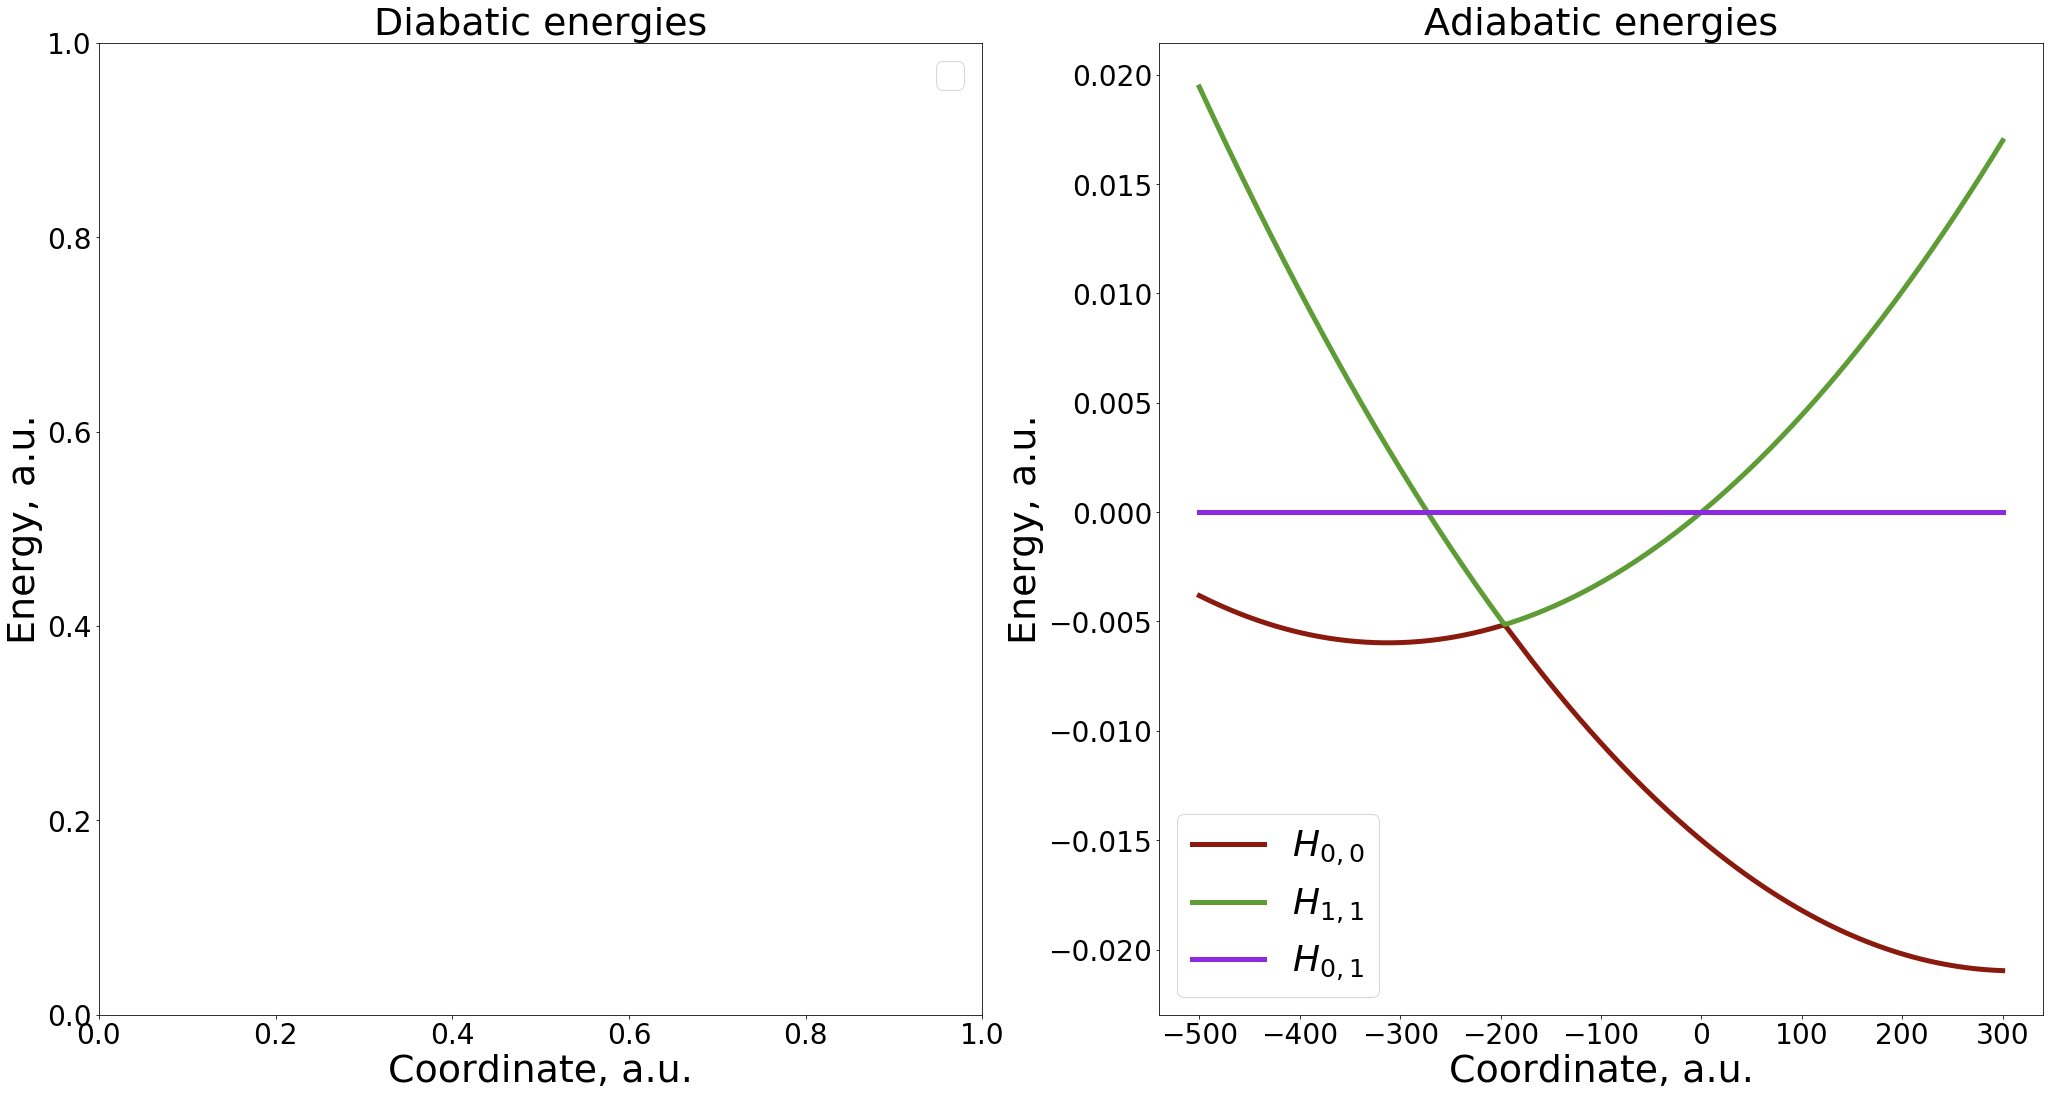

No handles with labels found to put in legend.


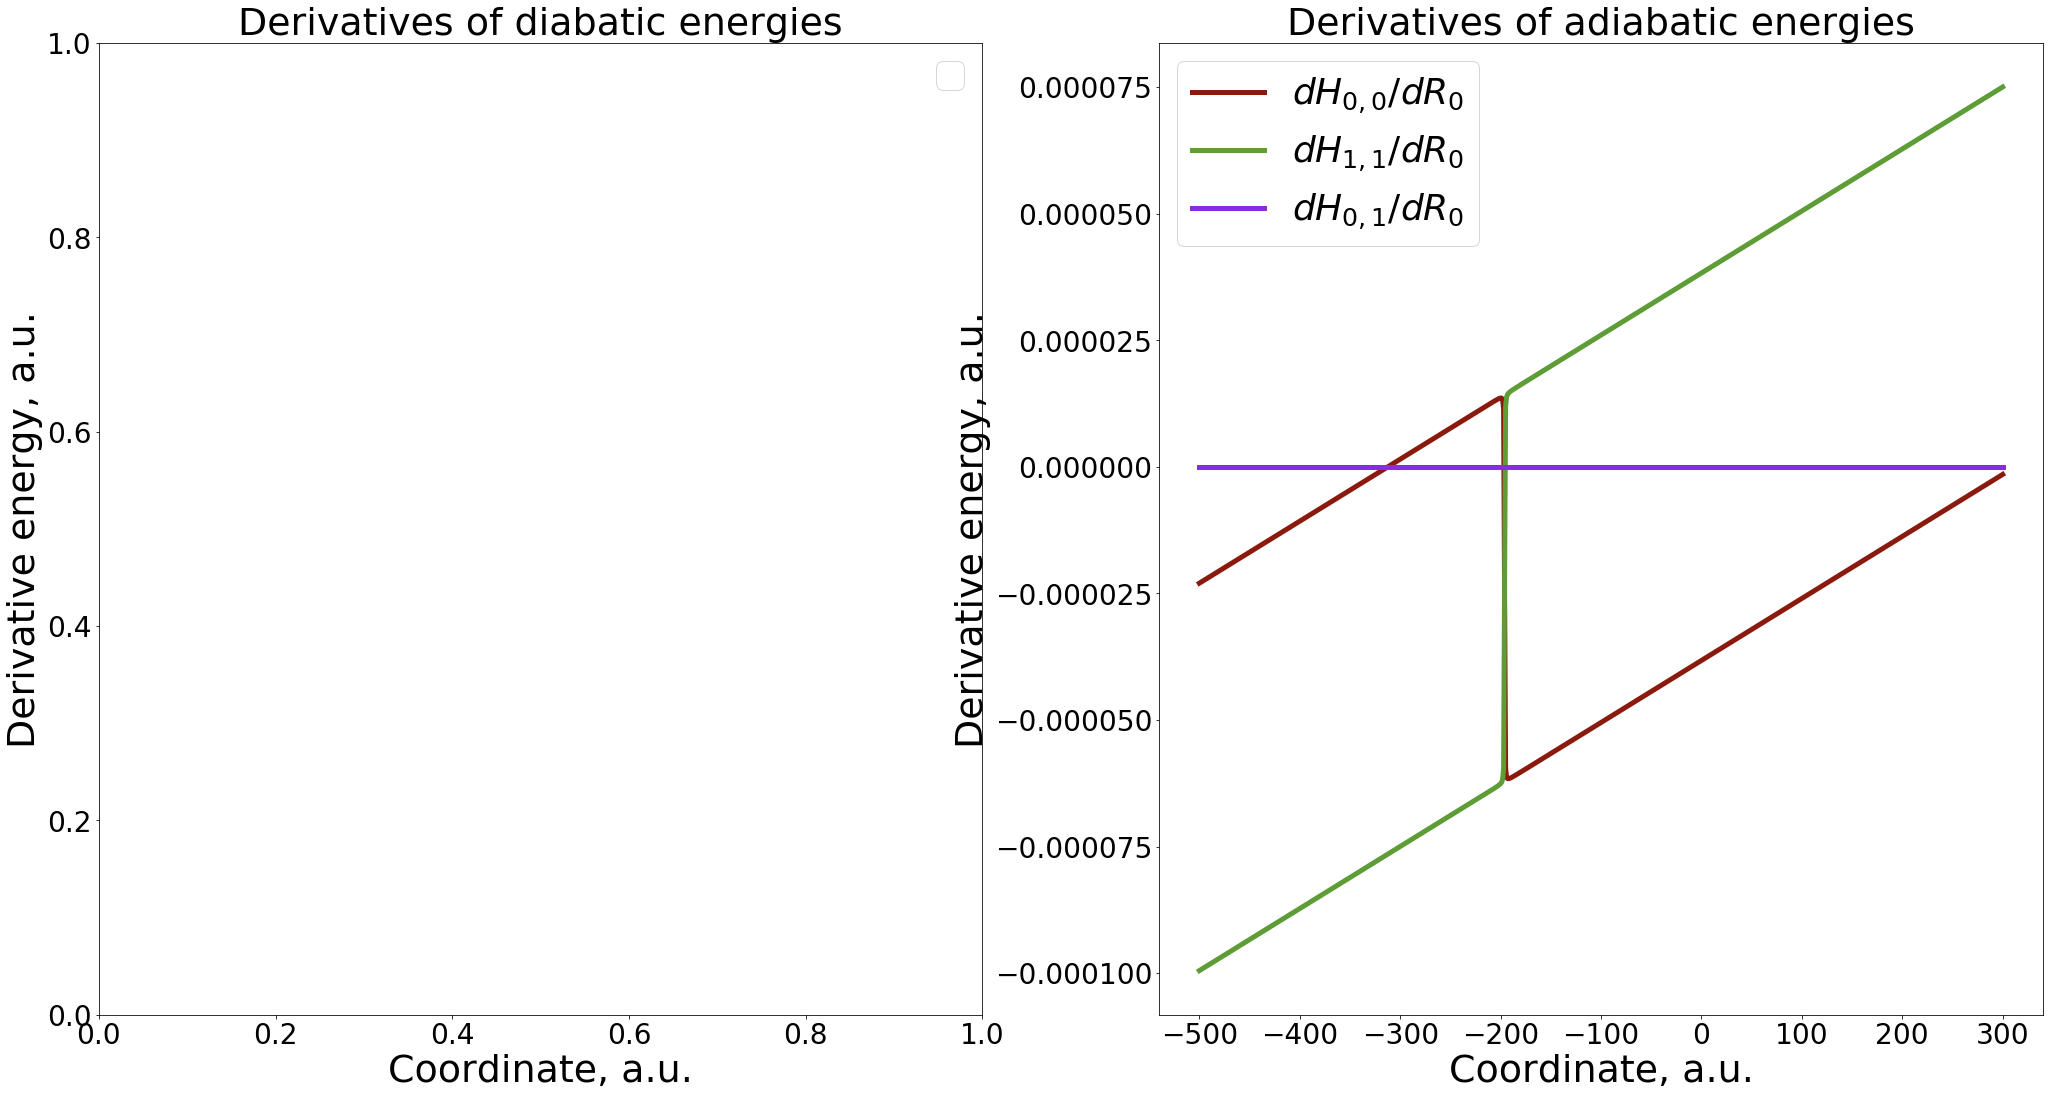

No handles with labels found to put in legend.


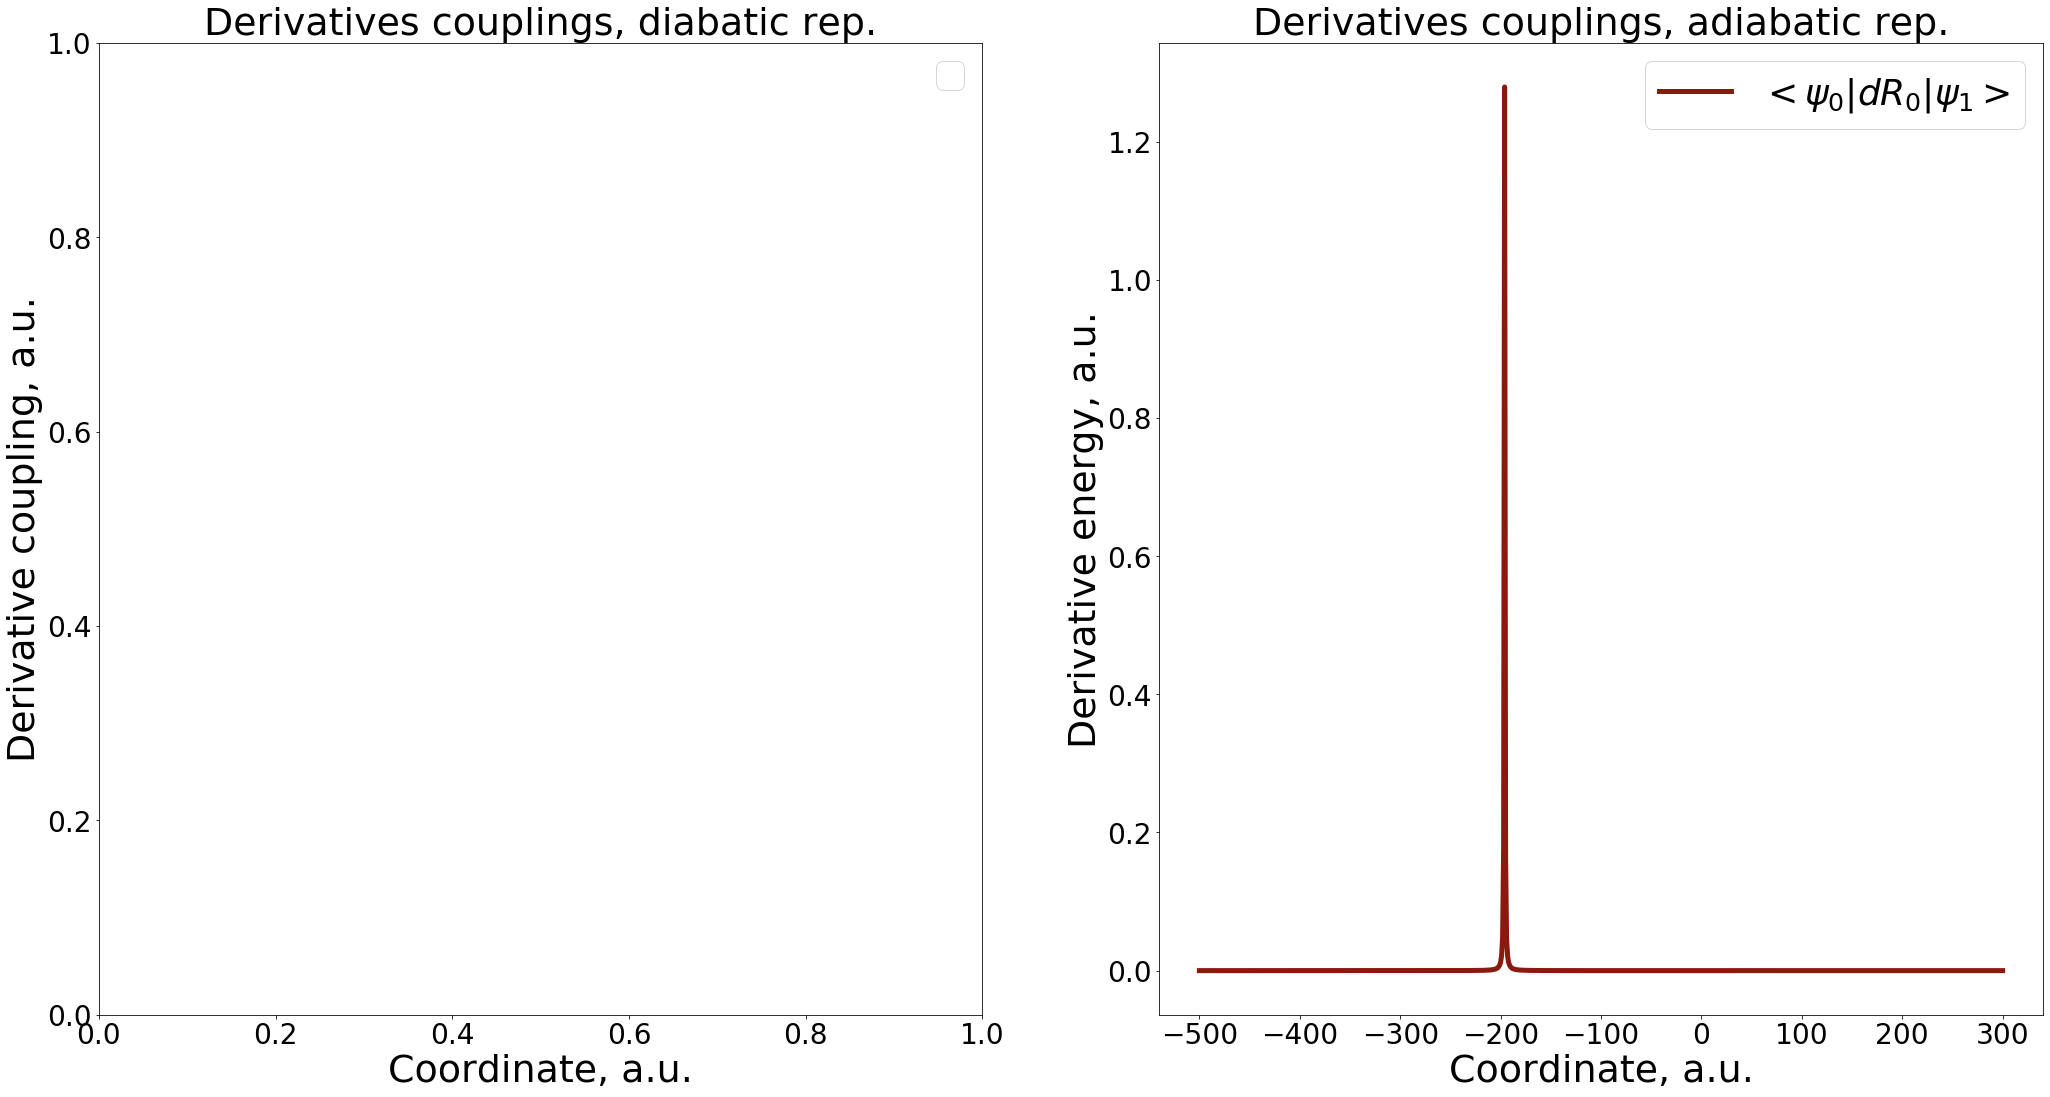

In [11]:
pes_params = { "ndia":2, "nadi":2, "ndof":1,
               "xmin":-500.0, "xmax":300.0, "dx":1.0,
               "rep_tdse":1, "rep_ham":1  }

plot_params = { "which_ham_adi":[ [0,0], [1,1], [0,1] ],
                "which_d1ham_adi":[ [0, 0,0], [0, 1,1], [0, 0,1] ],
                "which_dc1_adi":[ [0, 0,1] ]                
              }

dynamics_plotting.plot_pes_properties(compute_model, {"model":2}, pes_params, plot_params )

<a name="pes_scan-4"></a>
[Back to TOC](#TOC)

### 2.4. Option 4: Adiabatic properties via file-based Hamiltonian

In this section we are going to use the Hamiltonian, whose "computation" is nothing but reading files and spitting some energies. This can be used in the NBRA-type calculations, so nuclear geometry is really redundant here. Instead, our "scan" will be with respect to time, which is parameterized by the `timestep` variable passed to the Hamiltonian.

However, we would first need to create a file that we would then pretend was given to us from 3-rd part calculations. The file shall be in the HDF5 format or and will contain certain types of datasets. However, there is not restriction on these sides - any other file formats (e.g. multiple files) could be used. This depends on the the "computing" function - we can always adapt it to the type of files and formats that wwe anticipate of having.


This function also demonstrates the use of the `hdf5_saver` class defined in `libra_py.data_saers` module.

This use of this function goes as follows: 

<a name="hdf5_saver"></a>     
1. instantiate an object by calling a constructor of this class. 

       hdf5_saver = data_savers.hdf5_saver(F"{output_prefix}/data.hdf", ["hvib_adi"])   

  The constructor takes the following arguments:

   - the name of the HDF5 file to be associated with this object, in this example it is `{output_prefix}/data.hdf`
     
     This means that the actual HDF5 file that you'll have will be "data.hdf", and it will be located in the folder  defined by the variable `output_prefix`
     
   - the list of the dataset names, in this example it consists of only `hvib_adi`. 
   
   NOTE: it is very important to define this list - otherwise nothing will be saved to the file, even if you tell the code to save those datasets.
     
<a name="set_compression_level"></a>     
2. set comptession levels

        hdf5_saver.set_compression_level(0, [0,0,0])   
        
   So far, is it better not to use any compression (the first argument = 0). Otherwise, the files become very large  and processing is much slower.
   In case you decide to use the compression of data, the 3 integers in the second argument (list) set the level of compression for ints (first), doubles/floats (second), and complex (third) numbers.
   
<a name="add_dataset"></a>
3. allocate a dataset 

        hdf5_saver.add_dataset("hvib_adi", (nsteps, nstates, nstates), "C")       
        
   In this function call:
   
     - `hvib_adi` - specifies the name of the dataset to be allocated
     - `(nsteps, nstates, nstates)` - defines the dimensionality and shape of the dataset - in this example we allocate `nsteps` matrices `nstates` $\times$ `nstates`
     - `C` - speficies that each element of the dataset is a complex number
   
<a name="save_matrix"></a>
4. compute and save the matrices 

        hdf5_saver.save_matrix(step, "hvib_adi", hvib)
        
   In each step of the loop we create a new matrix `hvib = CMATRIX(nstates,nstates)`, then populate it with whatever numbers we need. Then we same this `nstates` $\times$ `nstates` in the element `step` of the allocated dataset (a 3D numpy array) called "hvib_adi"
   

In [12]:
def auxiliary_file_creator(nsteps, output_prefix):
    
    nstates = 2
    
    # Create an output directory, if not present    
    if not os.path.isdir(output_prefix):
        os.mkdir(output_prefix)    
    
        
    hdf5_saver = data_savers.hdf5_saver(F"{output_prefix}/data.hdf", ["hvib_adi"]) 
    hdf5_saver.set_compression_level(0, [0,0,0])   
    hdf5_saver.add_dataset("hvib_adi", (nsteps, nstates, nstates), "C")       
    
    for step in range(nsteps):
        
        hvib = CMATRIX(nstates,nstates)
        
        e0 = (-0.01 + 0.001*math.cos(2.0*math.pi*step/50.0)) * (1.0+0.0j)
        e1 = (0.01 + 0.002*math.cos(2.0*math.pi*step/30.0) ) * (1.0+0.0j)
        d01 = (0.1/(e1-e0) ) * (0.0 + 1.0j)
        
        hvib.set(0,0, e0);    hvib.set(0,1, d01);
        hvib.set(1,0, -d01);  hvib.set(1,1, e1);
                    
        hdf5_saver.save_matrix(step, "hvib_adi", hvib)
        

Now, lets generate the file with 1000 timesteps and save it in the directory named "file_hamiltonian".

Note the message on the datasets that **can** be saved to the file - this a double check that you are actually saving what you think. Remember - this is defined by the list of the dataset names that you provide to the constructor.

In [13]:
auxiliary_file_creator(1000, "file_hamiltonian")

HDF5 saver is initialized...
the datasets that can be saved are: ['hvib_adi']


[Back to TOC](#TOC)

### Some fun with HDF5 files 

Here is a little be of generic stuff on handling HDF5 files.

#### 1. Getting to know an HDF5 file content

Imagine you have a file `file_hamiltonian/data.hdf`, but you have no idea on what datasets it contains. 

You can check it like this:

In [14]:
with h5py.File("file_hamiltonian/data.hdf", 'r') as f:
    print( list(f.keys() ) )

['default', 'hvib_adi']


#### 2. Determining the dimensions of the HDF5 datasets

Now that you know there is a `hvib_adi` data set, you'd like to know its size and dimensionality. 

This is done via the `shape` attribute:

In [14]:
with h5py.File("file_hamiltonian/data.hdf", 'r') as f:
    print( (f["hvib_adi/data"].shape) )

(1000, 2, 2)


This is very consistent with what we have created - we made 1000 entries, each of which is a 2 x 2 matrix

**IMPORTANT:** The `hdf5_saver` function `save_matrix` as well as any other saver functions in Libra will always create a sub-set of each dataset. The subset is always called `data` and it is what actually holds the numbers stored, not the named dataset itself. 
So, in assessing the shapes of the stored data arrays we have to go like `f["hvib_adi/data"]` and not just `f["hvib_adi"]`

#### 3. Accessing the data  of the HDF5 datasets

To access the data from the HDF5 files, simply open the files, "navigate" to the dataset (don't forget the trailing "/data") and handle this object as a regular numpy array, using the corresponding syntax. This works for as long as the file is open (in this example, withing the "with" scope). 

In [15]:
with h5py.File("file_hamiltonian/data.hdf", 'r') as f:
    print(f["hvib_adi/data"][0:10,0,0])

[-0.009     +0.j -0.00900789+0.j -0.00903142+0.j -0.00907022+0.j
 -0.00912369+0.j -0.00919098+0.j -0.00927103+0.j -0.00936258+0.j
 -0.00946417+0.j -0.00957422+0.j]


[Back to TOC](#TOC)


Finally, let us go back to our Hamiltonian plotting example.  

This is how it is done for a situation when the Hamiltonian is "computed" via reading the files

<a name="1d_pes_plotting3"></a>

No handles with labels found to put in legend.


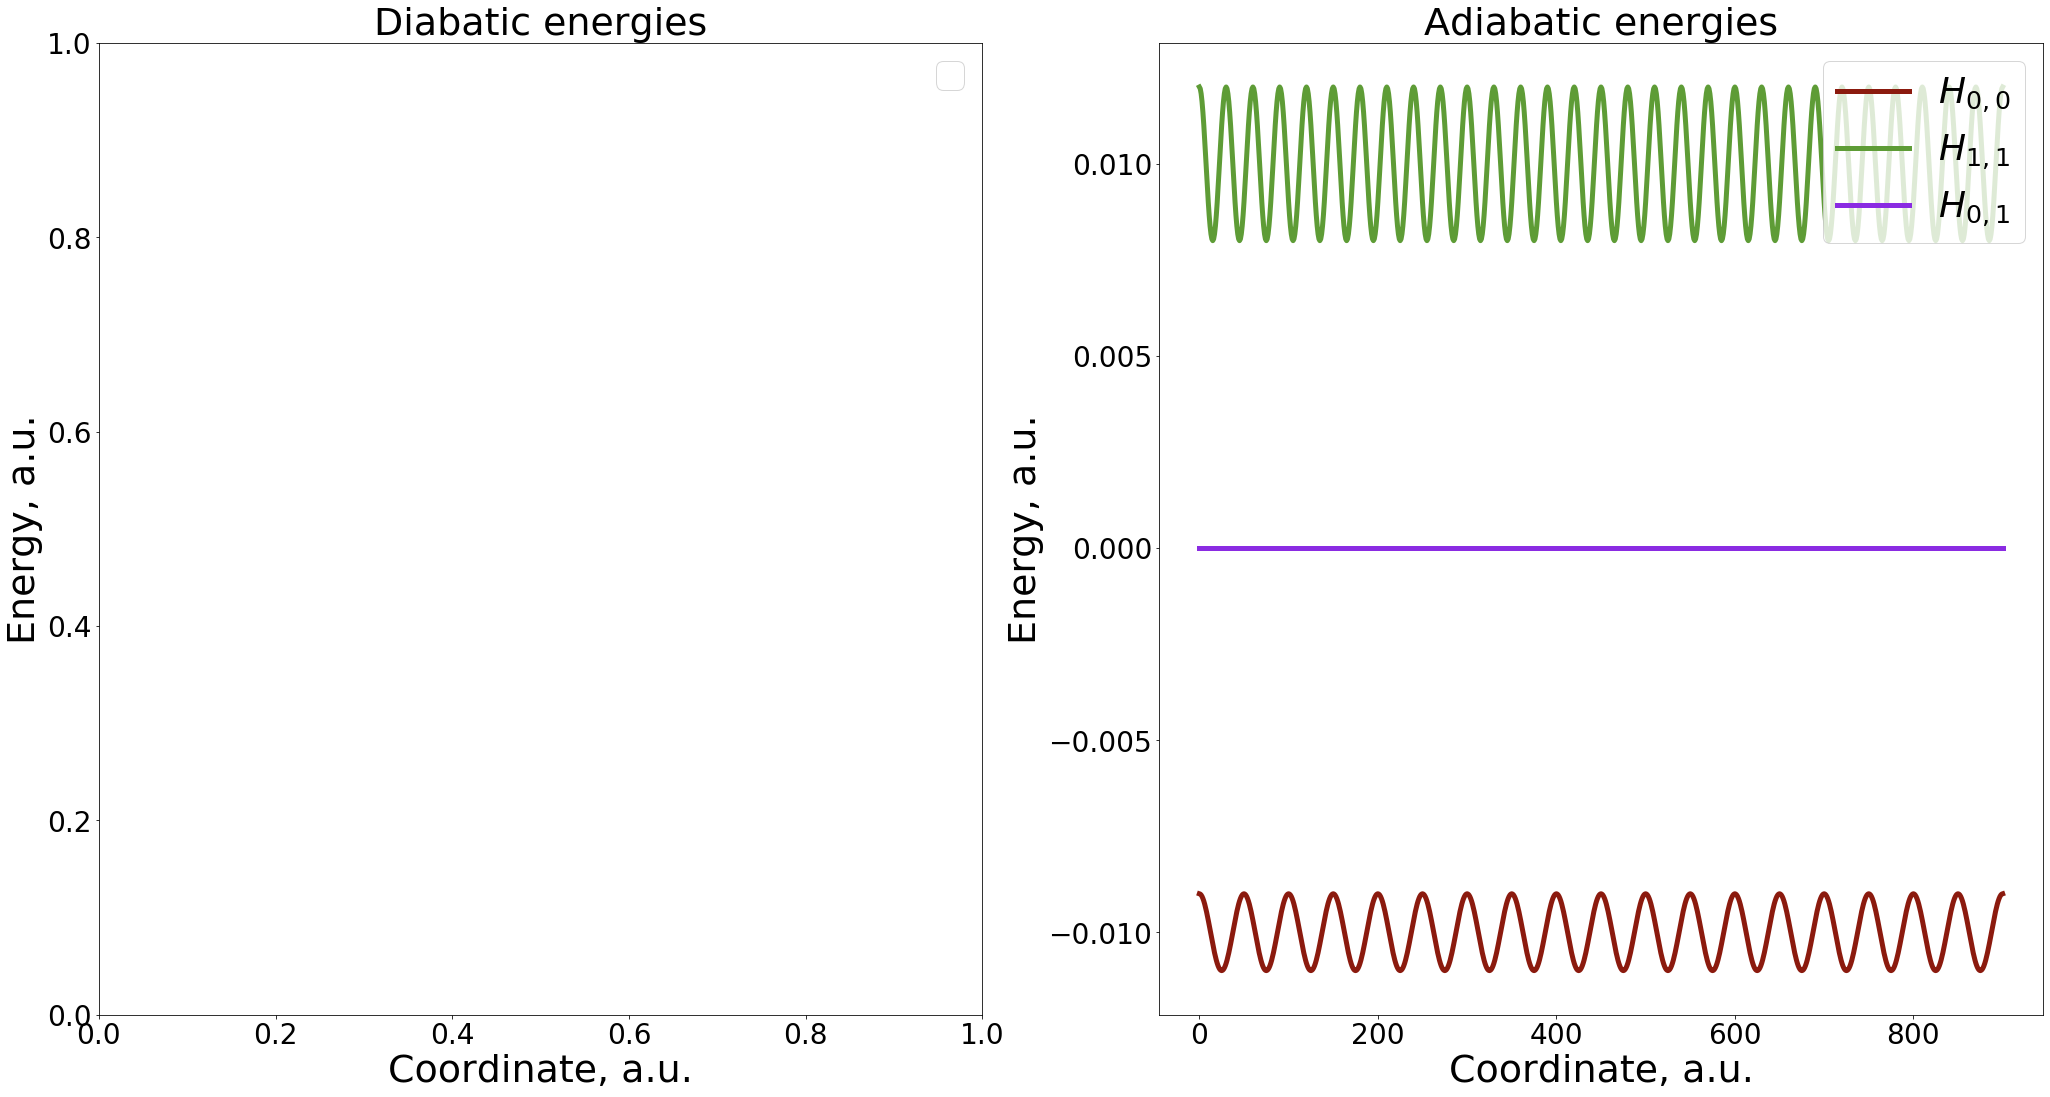

No handles with labels found to put in legend.


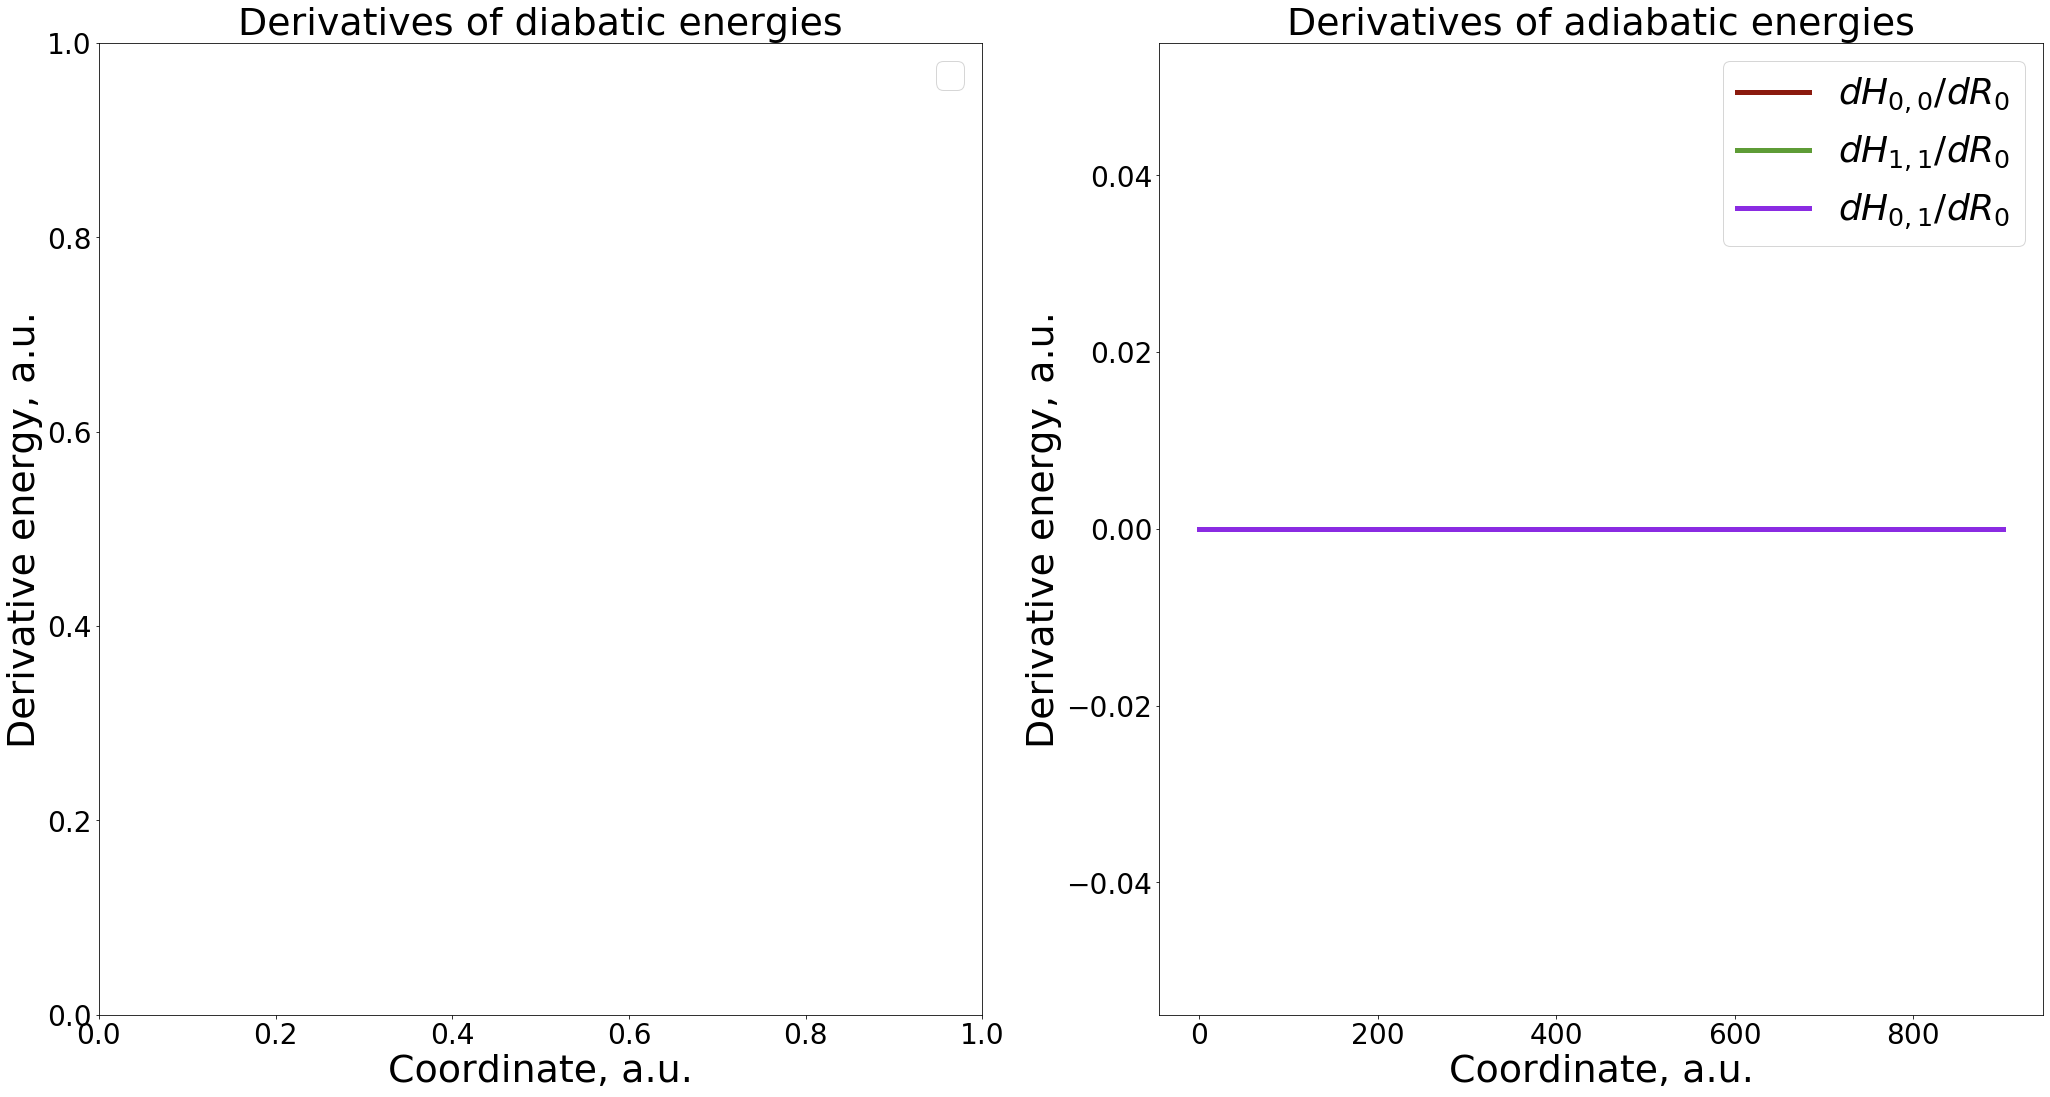

No handles with labels found to put in legend.


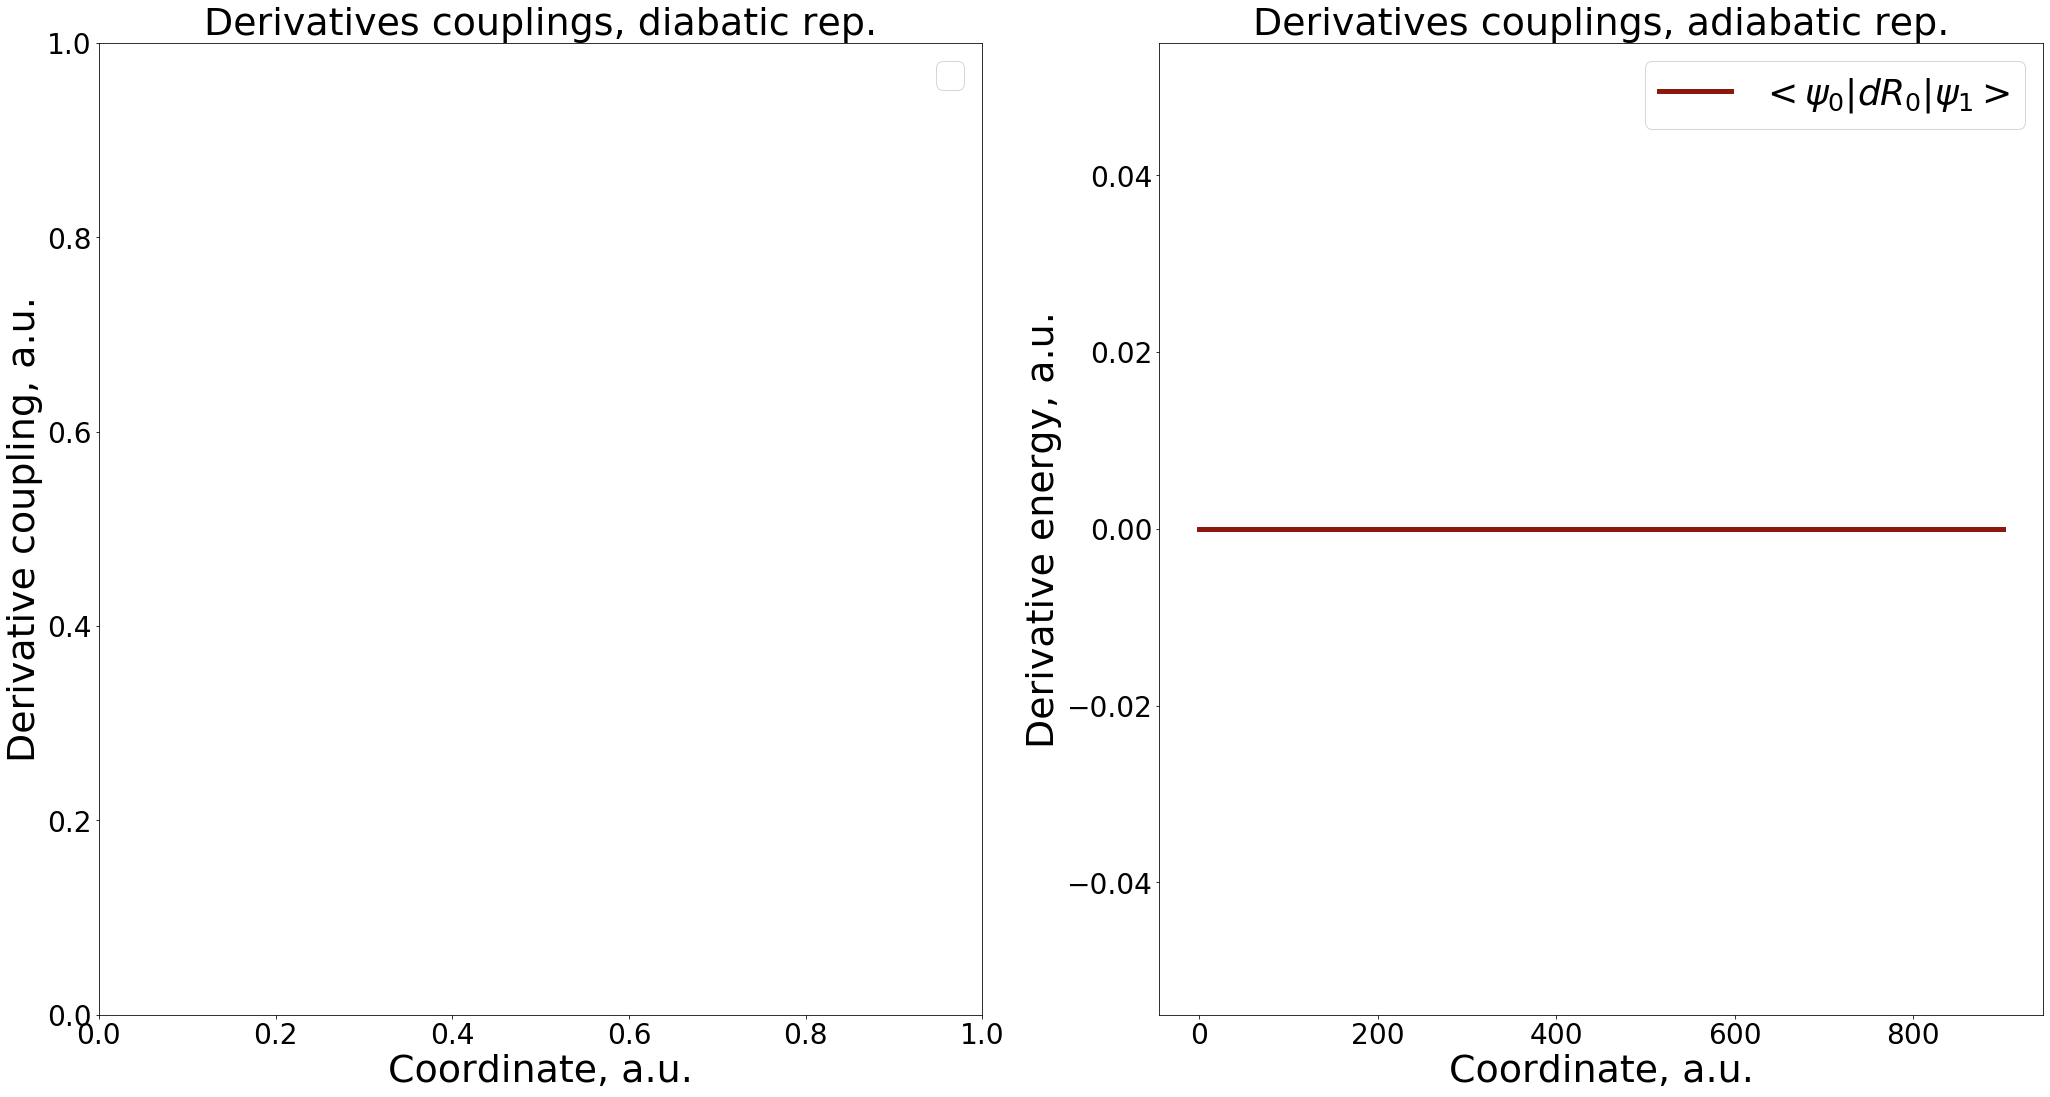

In [18]:
model_params = {"model":3, "filename":"file_hamiltonian/data.hdf"}

pes_params = { "ndia":2, "nadi":2, "ndof":1,
               "coord_type":1,
               "tmin":0, "tmax":900, "dt":1,
               "rep_tdse":1, "rep_ham":1  }

plot_params = { "which_ham_adi":[ [0,0], [1,1], [0,1] ],
                "which_d1ham_adi":[ [0, 0,0], [0, 1,1], [0, 0,1] ],
                "which_dc1_adi":[ [0, 0,1] ]                
              }

dynamics_plotting.plot_pes_properties(compute_model, model_params, pes_params, plot_params )

This example is very similar to the one we have above, with the following changes:

1. First, in the `model_params` argument (second argument) we specify:

   * `"model":3` - to select the file-based calculations model
   * `"filename":"file_hamiltonian/data.hdf"` - to define from which file will the numbers be taken
   
2. Second, in the `pes_params` we speficy:

   * `"coord_type":1` - to indicate that the index of the data-point will serve as our "coordinate" - this is a time-coordinate, if you will
   * `"tmin":0`, `"tmax":900`, `"dt":1` are used instead of `xmin`, `xmax`, and `dx` to specify the range of the datapoints to be plotted and their spacing.
   
3. Finally, as you can see - only the adiabatic energies are plotted above. This is because we only have these properties and nothing else. This is the way we defined our Hamiltonian model. Also, note the  section in the bottom of the `my_test_adi_files` function:

       obj.hvib_adi = H_vib_adi        
       obj.ham_adi = CMATRIX(H_vib_adi.real() )
       
   This defined not only the vibronic Hamiltonian matrices, but also the adiabatic Hamiltonian matrices (the last line). Should we not have it - the only non-empty plot in Figure above would be empty.